In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1094503, 828)
(1094503, 1)
validation
(161423, 828)
(161423, 1)
test
(128767, 828)
(128767, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/110 [..............................] - ETA: 2:10 - loss: 0.1047 - STD: 1.0453e-04 - MAE: 0.3113

  4/110 [>.............................] - ETA: 2s - loss: 0.0425 - STD: 3.4031e-04 - MAE: 0.1567  

  5/110 [>.............................] - ETA: 3s - loss: 0.0409 - STD: 3.1053e-04 - MAE: 0.1540

  6/110 [>.............................] - ETA: 3s - loss: 0.0404 - STD: 2.8272e-04 - MAE: 0.1536

  7/110 [>.............................] - ETA: 4s - loss: 0.0398 - STD: 2.6091e-04 - MAE: 0.1532

  8/110 [=>............................] - ETA: 4s - loss: 0.0391 - STD: 2.4578e-04 - MAE: 0.1517

  9/110 [=>............................] - ETA: 4s - loss: 0.0383 - STD: 2.3664e-04 - MAE: 0.1496

 10/110 [=>............................] - ETA: 10s - loss: 0.0378 - STD: 2.3315e-04 - MAE: 0.1464

 14/110 [==>...........................] - ETA: 7s - loss: 0.0319 - STD: 2.5388e-04 - MAE: 0.1271 

 15/110 [===>..........................] - ETA: 7s - loss: 0.0307 - STD: 2.6285e-04 - MAE: 0.1247

 16/110 [===>..........................] - ETA: 7s - loss: 0.0298 - STD: 2.7175e-04 - MAE: 0.1238

 17/110 [===>..........................] - ETA: 7s - loss: 0.0292 - STD: 2.8023e-04 - MAE: 0.1237

 18/110 [===>..........................] - ETA: 6s - loss: 0.0286 - STD: 2.8858e-04 - MAE: 0.1238

 19/110 [====>.........................] - ETA: 6s - loss: 0.0282 - STD: 2.9661e-04 - MAE: 0.1238

 20/110 [====>.........................] - ETA: 6s - loss: 0.0277 - STD: 3.0430e-04 - MAE: 0.1235

 21/110 [====>.........................] - ETA: 6s - loss: 0.0271 - STD: 3.1137e-04 - MAE: 0.1226

 22/110 [=====>........................] - ETA: 6s - loss: 0.0266 - STD: 3.1848e-04 - MAE: 0.1213

 23/110 [=====>........................] - ETA: 6s - loss: 0.0260 - STD: 3.2467e-04 - MAE: 0.1196

 24/110 [=====>........................] - ETA: 6s - loss: 0.0256 - STD: 3.3025e-04 - MAE: 0.1176

 25/110 [=====>........................] - ETA: 6s - loss: 0.0251 - STD: 3.3545e-04 - MAE: 0.1156

 26/110 [======>.......................] - ETA: 5s - loss: 0.0248 - STD: 3.4017e-04 - MAE: 0.1138

 27/110 [======>.......................] - ETA: 5s - loss: 0.0244 - STD: 3.4460e-04 - MAE: 0.1120

 28/110 [======>.......................] - ETA: 5s - loss: 0.0241 - STD: 3.4934e-04 - MAE: 0.1104

 29/110 [======>.......................] - ETA: 5s - loss: 0.0238 - STD: 3.5421e-04 - MAE: 0.1089

 30/110 [=======>......................] - ETA: 5s - loss: 0.0236 - STD: 3.5941e-04 - MAE: 0.1075

 31/110 [=======>......................] - ETA: 5s - loss: 0.0233 - STD: 3.6523e-04 - MAE: 0.1061

 32/110 [=======>......................] - ETA: 5s - loss: 0.0230 - STD: 3.7158e-04 - MAE: 0.1049

 33/110 [========>.....................] - ETA: 5s - loss: 0.0227 - STD: 3.7872e-04 - MAE: 0.1038

 34/110 [========>.....................] - ETA: 5s - loss: 0.0225 - STD: 3.8670e-04 - MAE: 0.1029

 35/110 [========>.....................] - ETA: 5s - loss: 0.0222 - STD: 3.9541e-04 - MAE: 0.1021

 36/110 [========>.....................] - ETA: 4s - loss: 0.0220 - STD: 4.0467e-04 - MAE: 0.1015

 37/110 [=========>....................] - ETA: 4s - loss: 0.0218 - STD: 4.1435e-04 - MAE: 0.1011

 38/110 [=========>....................] - ETA: 4s - loss: 0.0216 - STD: 4.2485e-04 - MAE: 0.1008

 39/110 [=========>....................] - ETA: 4s - loss: 0.0214 - STD: 4.3565e-04 - MAE: 0.1005

 40/110 [=========>....................] - ETA: 4s - loss: 0.0213 - STD: 4.4684e-04 - MAE: 0.1003

 41/110 [==========>...................] - ETA: 4s - loss: 0.0211 - STD: 4.5812e-04 - MAE: 0.0999

 42/110 [==========>...................] - ETA: 4s - loss: 0.0209 - STD: 4.7010e-04 - MAE: 0.0996

 43/110 [==========>...................] - ETA: 4s - loss: 0.0208 - STD: 4.8204e-04 - MAE: 0.0992

 44/110 [===========>..................] - ETA: 4s - loss: 0.0206 - STD: 4.9415e-04 - MAE: 0.0987

 45/110 [===========>..................] - ETA: 4s - loss: 0.0205 - STD: 5.0672e-04 - MAE: 0.0982

 46/110 [===========>..................] - ETA: 4s - loss: 0.0203 - STD: 5.1957e-04 - MAE: 0.0977

 47/110 [===========>..................] - ETA: 4s - loss: 0.0202 - STD: 5.3283e-04 - MAE: 0.0971

 48/110 [============>.................] - ETA: 4s - loss: 0.0201 - STD: 5.4646e-04 - MAE: 0.0966

 49/110 [============>.................] - ETA: 3s - loss: 0.0200 - STD: 5.6084e-04 - MAE: 0.0960

 50/110 [============>.................] - ETA: 3s - loss: 0.0198 - STD: 5.7624e-04 - MAE: 0.0955

 51/110 [============>.................] - ETA: 3s - loss: 0.0197 - STD: 5.9266e-04 - MAE: 0.0950

 52/110 [=============>................] - ETA: 3s - loss: 0.0196 - STD: 6.0981e-04 - MAE: 0.0945

 53/110 [=============>................] - ETA: 3s - loss: 0.0195 - STD: 6.2875e-04 - MAE: 0.0941

 54/110 [=============>................] - ETA: 3s - loss: 0.0194 - STD: 6.4878e-04 - MAE: 0.0938

 55/110 [==============>...............] - ETA: 3s - loss: 0.0193 - STD: 6.7064e-04 - MAE: 0.0935

 56/110 [==============>...............] - ETA: 3s - loss: 0.0192 - STD: 6.9427e-04 - MAE: 0.0932

 57/110 [==============>...............] - ETA: 3s - loss: 0.0191 - STD: 7.1886e-04 - MAE: 0.0930

 58/110 [==============>...............] - ETA: 3s - loss: 0.0191 - STD: 7.4535e-04 - MAE: 0.0928

 59/110 [===============>..............] - ETA: 3s - loss: 0.0190 - STD: 7.7313e-04 - MAE: 0.0925

 60/110 [===============>..............] - ETA: 3s - loss: 0.0189 - STD: 8.0299e-04 - MAE: 0.0924

 61/110 [===============>..............] - ETA: 3s - loss: 0.0188 - STD: 8.3432e-04 - MAE: 0.0921

 62/110 [===============>..............] - ETA: 3s - loss: 0.0187 - STD: 8.6718e-04 - MAE: 0.0919

 63/110 [================>.............] - ETA: 3s - loss: 0.0187 - STD: 9.0267e-04 - MAE: 0.0917

 64/110 [================>.............] - ETA: 2s - loss: 0.0186 - STD: 9.3934e-04 - MAE: 0.0914

 65/110 [================>.............] - ETA: 2s - loss: 0.0185 - STD: 9.7879e-04 - MAE: 0.0912

 66/110 [=================>............] - ETA: 2s - loss: 0.0184 - STD: 0.0010 - MAE: 0.0909    

 67/110 [=================>............] - ETA: 2s - loss: 0.0184 - STD: 0.0011 - MAE: 0.0906

 68/110 [=================>............] - ETA: 2s - loss: 0.0183 - STD: 0.0011 - MAE: 0.0904

 69/110 [=================>............] - ETA: 2s - loss: 0.0182 - STD: 0.0012 - MAE: 0.0901

 70/110 [==================>...........] - ETA: 2s - loss: 0.0182 - STD: 0.0012 - MAE: 0.0898

 71/110 [==================>...........] - ETA: 2s - loss: 0.0181 - STD: 0.0013 - MAE: 0.0896

 72/110 [==================>...........] - ETA: 2s - loss: 0.0180 - STD: 0.0013 - MAE: 0.0894

 73/110 [==================>...........] - ETA: 2s - loss: 0.0180 - STD: 0.0014 - MAE: 0.0892

 74/110 [===================>..........] - ETA: 2s - loss: 0.0179 - STD: 0.0015 - MAE: 0.0890

 75/110 [===================>..........] - ETA: 2s - loss: 0.0179 - STD: 0.0016 - MAE: 0.0889

 76/110 [===================>..........] - ETA: 2s - loss: 0.0178 - STD: 0.0017 - MAE: 0.0887

 77/110 [====================>.........] - ETA: 2s - loss: 0.0177 - STD: 0.0018 - MAE: 0.0885

 78/110 [====================>.........] - ETA: 2s - loss: 0.0177 - STD: 0.0019 - MAE: 0.0884

 79/110 [====================>.........] - ETA: 1s - loss: 0.0176 - STD: 0.0020 - MAE: 0.0882

 80/110 [====================>.........] - ETA: 1s - loss: 0.0176 - STD: 0.0021 - MAE: 0.0880

 81/110 [=====================>........] - ETA: 1s - loss: 0.0175 - STD: 0.0022 - MAE: 0.0878

 82/110 [=====================>........] - ETA: 1s - loss: 0.0174 - STD: 0.0024 - MAE: 0.0875

 83/110 [=====================>........] - ETA: 1s - loss: 0.0174 - STD: 0.0025 - MAE: 0.0873

 84/110 [=====================>........] - ETA: 1s - loss: 0.0173 - STD: 0.0027 - MAE: 0.0871

 85/110 [======================>.......] - ETA: 1s - loss: 0.0172 - STD: 0.0028 - MAE: 0.0868

 86/110 [======================>.......] - ETA: 1s - loss: 0.0172 - STD: 0.0030 - MAE: 0.0866

 87/110 [======================>.......] - ETA: 1s - loss: 0.0171 - STD: 0.0032 - MAE: 0.0863

 88/110 [=======================>......] - ETA: 1s - loss: 0.0170 - STD: 0.0035 - MAE: 0.0861

 89/110 [=======================>......] - ETA: 1s - loss: 0.0169 - STD: 0.0037 - MAE: 0.0859

 90/110 [=======================>......] - ETA: 1s - loss: 0.0169 - STD: 0.0040 - MAE: 0.0857

 91/110 [=======================>......] - ETA: 1s - loss: 0.0168 - STD: 0.0042 - MAE: 0.0854

 92/110 [========================>.....] - ETA: 1s - loss: 0.0167 - STD: 0.0045 - MAE: 0.0852

 93/110 [========================>.....] - ETA: 1s - loss: 0.0167 - STD: 0.0049 - MAE: 0.0850

 94/110 [========================>.....] - ETA: 1s - loss: 0.0166 - STD: 0.0052 - MAE: 0.0847

 95/110 [========================>.....] - ETA: 0s - loss: 0.0165 - STD: 0.0056 - MAE: 0.0845

 96/110 [=========================>....] - ETA: 0s - loss: 0.0164 - STD: 0.0060 - MAE: 0.0842

 97/110 [=========================>....] - ETA: 0s - loss: 0.0163 - STD: 0.0064 - MAE: 0.0839

 98/110 [=========================>....] - ETA: 0s - loss: 0.0162 - STD: 0.0068 - MAE: 0.0836

 99/110 [==========================>...] - ETA: 0s - loss: 0.0162 - STD: 0.0073 - MAE: 0.0833

100/110 [==========================>...] - ETA: 0s - loss: 0.0161 - STD: 0.0077 - MAE: 0.0830

101/110 [==========================>...] - ETA: 0s - loss: 0.0160 - STD: 0.0082 - MAE: 0.0827

102/110 [==========================>...] - ETA: 0s - loss: 0.0159 - STD: 0.0087 - MAE: 0.0823

103/110 [===========================>..] - ETA: 0s - loss: 0.0158 - STD: 0.0093 - MAE: 0.0820

104/110 [===========================>..] - ETA: 0s - loss: 0.0157 - STD: 0.0098 - MAE: 0.0817

105/110 [===========================>..] - ETA: 0s - loss: 0.0156 - STD: 0.0104 - MAE: 0.0814

106/110 [===========================>..] - ETA: 0s - loss: 0.0155 - STD: 0.0110 - MAE: 0.0811

107/110 [============================>.] - ETA: 0s - loss: 0.0154 - STD: 0.0116 - MAE: 0.0808

108/110 [============================>.] - ETA: 0s - loss: 0.0153 - STD: 0.0121 - MAE: 0.0804

109/110 [============================>.] - ETA: 0s - loss: 0.0152 - STD: 0.0128 - MAE: 0.0801

110/110 [==============================] - ETA: 0s - loss: 0.0151 - STD: 0.0134 - MAE: 0.0798

110/110 [==============================] - 9s 69ms/step - loss: 0.0151 - STD: 0.0134 - MAE: 0.0798 - val_loss: 0.0066 - val_STD: 0.0686 - val_MAE: 0.0506


Epoch 2/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0051 - STD: 0.0840 - MAE: 0.0454

  2/110 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0853 - MAE: 0.0452

  3/110 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0857 - MAE: 0.0450

  4/110 [>.............................] - ETA: 6s - loss: 0.0049 - STD: 0.0855 - MAE: 0.0446

  5/110 [>.............................] - ETA: 6s - loss: 0.0048 - STD: 0.0861 - MAE: 0.0442

  6/110 [>.............................] - ETA: 6s - loss: 0.0048 - STD: 0.0872 - MAE: 0.0442

  7/110 [>.............................] - ETA: 6s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0439

  8/110 [=>............................] - ETA: 6s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0438

  9/110 [=>............................] - ETA: 6s - loss: 0.0047 - STD: 0.0895 - MAE: 0.0437

 10/110 [=>............................] - ETA: 6s - loss: 0.0047 - STD: 0.0898 - MAE: 0.0435

 11/110 [==>...........................] - ETA: 6s - loss: 0.0046 - STD: 0.0902 - MAE: 0.0433

 12/110 [==>...........................] - ETA: 5s - loss: 0.0046 - STD: 0.0906 - MAE: 0.0430

 13/110 [==>...........................] - ETA: 5s - loss: 0.0046 - STD: 0.0912 - MAE: 0.0429

 14/110 [==>...........................] - ETA: 5s - loss: 0.0045 - STD: 0.0917 - MAE: 0.0428

 15/110 [===>..........................] - ETA: 5s - loss: 0.0045 - STD: 0.0920 - MAE: 0.0426

 16/110 [===>..........................] - ETA: 5s - loss: 0.0045 - STD: 0.0924 - MAE: 0.0425

 17/110 [===>..........................] - ETA: 5s - loss: 0.0044 - STD: 0.0925 - MAE: 0.0424

 18/110 [===>..........................] - ETA: 5s - loss: 0.0044 - STD: 0.0928 - MAE: 0.0423

 19/110 [====>.........................] - ETA: 5s - loss: 0.0044 - STD: 0.0932 - MAE: 0.0422

 20/110 [====>.........................] - ETA: 5s - loss: 0.0044 - STD: 0.0935 - MAE: 0.0421

 21/110 [====>.........................] - ETA: 5s - loss: 0.0043 - STD: 0.0939 - MAE: 0.0420

 22/110 [=====>........................] - ETA: 5s - loss: 0.0043 - STD: 0.0941 - MAE: 0.0419

 23/110 [=====>........................] - ETA: 5s - loss: 0.0043 - STD: 0.0943 - MAE: 0.0418

 24/110 [=====>........................] - ETA: 5s - loss: 0.0043 - STD: 0.0947 - MAE: 0.0418

 25/110 [=====>........................] - ETA: 5s - loss: 0.0043 - STD: 0.0951 - MAE: 0.0417

 26/110 [======>.......................] - ETA: 5s - loss: 0.0043 - STD: 0.0953 - MAE: 0.0416

 27/110 [======>.......................] - ETA: 5s - loss: 0.0042 - STD: 0.0956 - MAE: 0.0415

 28/110 [======>.......................] - ETA: 5s - loss: 0.0042 - STD: 0.0956 - MAE: 0.0414

 29/110 [======>.......................] - ETA: 5s - loss: 0.0042 - STD: 0.0958 - MAE: 0.0413

 30/110 [=======>......................] - ETA: 5s - loss: 0.0042 - STD: 0.0961 - MAE: 0.0413

 31/110 [=======>......................] - ETA: 4s - loss: 0.0042 - STD: 0.0962 - MAE: 0.0412

 32/110 [=======>......................] - ETA: 4s - loss: 0.0041 - STD: 0.0964 - MAE: 0.0411

 33/110 [========>.....................] - ETA: 4s - loss: 0.0041 - STD: 0.0965 - MAE: 0.0410

 34/110 [========>.....................] - ETA: 4s - loss: 0.0041 - STD: 0.0966 - MAE: 0.0410

 35/110 [========>.....................] - ETA: 4s - loss: 0.0041 - STD: 0.0968 - MAE: 0.0409

 36/110 [========>.....................] - ETA: 4s - loss: 0.0041 - STD: 0.0969 - MAE: 0.0409

 37/110 [=========>....................] - ETA: 4s - loss: 0.0041 - STD: 0.0970 - MAE: 0.0408

 38/110 [=========>....................] - ETA: 4s - loss: 0.0040 - STD: 0.0970 - MAE: 0.0407

 39/110 [=========>....................] - ETA: 4s - loss: 0.0040 - STD: 0.0971 - MAE: 0.0407

 40/110 [=========>....................] - ETA: 4s - loss: 0.0040 - STD: 0.0973 - MAE: 0.0407

 41/110 [==========>...................] - ETA: 4s - loss: 0.0040 - STD: 0.0975 - MAE: 0.0406

 42/110 [==========>...................] - ETA: 4s - loss: 0.0040 - STD: 0.0976 - MAE: 0.0405

 43/110 [==========>...................] - ETA: 4s - loss: 0.0040 - STD: 0.0977 - MAE: 0.0405

 44/110 [===========>..................] - ETA: 4s - loss: 0.0040 - STD: 0.0979 - MAE: 0.0404

 45/110 [===========>..................] - ETA: 4s - loss: 0.0039 - STD: 0.0979 - MAE: 0.0404

 46/110 [===========>..................] - ETA: 3s - loss: 0.0039 - STD: 0.0981 - MAE: 0.0403

 47/110 [===========>..................] - ETA: 3s - loss: 0.0039 - STD: 0.0982 - MAE: 0.0403

 48/110 [============>.................] - ETA: 3s - loss: 0.0039 - STD: 0.0983 - MAE: 0.0402

 49/110 [============>.................] - ETA: 3s - loss: 0.0039 - STD: 0.0984 - MAE: 0.0402

 50/110 [============>.................] - ETA: 3s - loss: 0.0039 - STD: 0.0985 - MAE: 0.0401

 51/110 [============>.................] - ETA: 3s - loss: 0.0039 - STD: 0.0986 - MAE: 0.0401

 52/110 [=============>................] - ETA: 3s - loss: 0.0039 - STD: 0.0987 - MAE: 0.0400

 53/110 [=============>................] - ETA: 3s - loss: 0.0038 - STD: 0.0988 - MAE: 0.0399

 54/110 [=============>................] - ETA: 3s - loss: 0.0038 - STD: 0.0988 - MAE: 0.0399

 55/110 [==============>...............] - ETA: 3s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0398

 56/110 [==============>...............] - ETA: 3s - loss: 0.0038 - STD: 0.0990 - MAE: 0.0398

 57/110 [==============>...............] - ETA: 3s - loss: 0.0038 - STD: 0.0991 - MAE: 0.0397

 58/110 [==============>...............] - ETA: 3s - loss: 0.0038 - STD: 0.0992 - MAE: 0.0397

 59/110 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0993 - MAE: 0.0396

 60/110 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0994 - MAE: 0.0396

 61/110 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0395

 62/110 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0395

 63/110 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0394

 64/110 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0394

 65/110 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0393

 66/110 [=================>............] - ETA: 2s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0393

 67/110 [=================>............] - ETA: 2s - loss: 0.0037 - STD: 0.1000 - MAE: 0.0392

 68/110 [=================>............] - ETA: 2s - loss: 0.0037 - STD: 0.1000 - MAE: 0.0392

 69/110 [=================>............] - ETA: 2s - loss: 0.0037 - STD: 0.1001 - MAE: 0.0392

 70/110 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.1001 - MAE: 0.0391

 71/110 [==================>...........] - ETA: 2s - loss: 0.0036 - STD: 0.1002 - MAE: 0.0391

 72/110 [==================>...........] - ETA: 2s - loss: 0.0036 - STD: 0.1003 - MAE: 0.0390

 73/110 [==================>...........] - ETA: 2s - loss: 0.0036 - STD: 0.1003 - MAE: 0.0390

 74/110 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.1004 - MAE: 0.0389

 75/110 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.1004 - MAE: 0.0389

 76/110 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.1005 - MAE: 0.0388

 77/110 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.1006 - MAE: 0.0388

 78/110 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.1007 - MAE: 0.0388

 79/110 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.1008 - MAE: 0.0387

 80/110 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.1008 - MAE: 0.0387

 81/110 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.1009 - MAE: 0.0386

 82/110 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.1009 - MAE: 0.0386

 83/110 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0386

 84/110 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0385

 85/110 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.1011 - MAE: 0.0385

 86/110 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.1011 - MAE: 0.0384

 87/110 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0384

 88/110 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.1013 - MAE: 0.0383

 89/110 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.1013 - MAE: 0.0383

 90/110 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0383

 91/110 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0382

 92/110 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0382

 93/110 [========================>.....] - ETA: 1s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0381

 94/110 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0381

 95/110 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.1016 - MAE: 0.0380

 96/110 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.1016 - MAE: 0.0380

 97/110 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.1017 - MAE: 0.0380

 98/110 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.1017 - MAE: 0.0379

 99/110 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1018 - MAE: 0.0379

101/110 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1018 - MAE: 0.0378

102/110 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1019 - MAE: 0.0378

103/110 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1020 - MAE: 0.0377

104/110 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1020 - MAE: 0.0377

105/110 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0377

106/110 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0376

107/110 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1022 - MAE: 0.0376

108/110 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1022 - MAE: 0.0376

109/110 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1023 - MAE: 0.0375

110/110 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1023 - MAE: 0.0375

110/110 [==============================] - 7s 64ms/step - loss: 0.0033 - STD: 0.1023 - MAE: 0.0375 - val_loss: 0.0025 - val_STD: 0.0962 - val_MAE: 0.0344


Epoch 3/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0026 - STD: 0.1065 - MAE: 0.0339

  2/110 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.1055 - MAE: 0.0340

  3/110 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1069 - MAE: 0.0339

  4/110 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1067 - MAE: 0.0337

  5/110 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1063 - MAE: 0.0336

  6/110 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1069 - MAE: 0.0336

  7/110 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1071 - MAE: 0.0336

  8/110 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1072 - MAE: 0.0337

  9/110 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1071 - MAE: 0.0336

 10/110 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.1070 - MAE: 0.0336

 11/110 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.1069 - MAE: 0.0336

 12/110 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.1069 - MAE: 0.0336

 13/110 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.1066 - MAE: 0.0335

 14/110 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.1065 - MAE: 0.0335

 15/110 [===>..........................] - ETA: 5s - loss: 0.0025 - STD: 0.1066 - MAE: 0.0335

 16/110 [===>..........................] - ETA: 5s - loss: 0.0025 - STD: 0.1066 - MAE: 0.0334

 17/110 [===>..........................] - ETA: 5s - loss: 0.0025 - STD: 0.1067 - MAE: 0.0334

 19/110 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.1072 - MAE: 0.0334

 20/110 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.1071 - MAE: 0.0334

 21/110 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.1072 - MAE: 0.0334

 22/110 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1075 - MAE: 0.0334

 23/110 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1074 - MAE: 0.0334

 24/110 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.1072 - MAE: 0.0334

 25/110 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.1073 - MAE: 0.0333

 26/110 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.1073 - MAE: 0.0333

 27/110 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.1073 - MAE: 0.0333

 28/110 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.1072 - MAE: 0.0333

 29/110 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.1072 - MAE: 0.0333

 30/110 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.1072 - MAE: 0.0333

 31/110 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.1073 - MAE: 0.0333

 32/110 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.1074 - MAE: 0.0333

 33/110 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.1074 - MAE: 0.0333

 34/110 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.1073 - MAE: 0.0333

 35/110 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.1074 - MAE: 0.0332

 36/110 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.1074 - MAE: 0.0332

 37/110 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1073 - MAE: 0.0332

 38/110 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1074 - MAE: 0.0332

 39/110 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1074 - MAE: 0.0332

 40/110 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1073 - MAE: 0.0332

 41/110 [==========>...................] - ETA: 4s - loss: 0.0025 - STD: 0.1074 - MAE: 0.0332

 42/110 [==========>...................] - ETA: 4s - loss: 0.0025 - STD: 0.1074 - MAE: 0.0332

 43/110 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.1074 - MAE: 0.0332

 44/110 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.1075 - MAE: 0.0331

 45/110 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.1075 - MAE: 0.0331

 46/110 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.1075 - MAE: 0.0331

 47/110 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.1076 - MAE: 0.0331

 48/110 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.1077 - MAE: 0.0331

 49/110 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.1077 - MAE: 0.0331

 50/110 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.1076 - MAE: 0.0331

 51/110 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.1077 - MAE: 0.0331

 52/110 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.1077 - MAE: 0.0331

 53/110 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.1077 - MAE: 0.0331

 54/110 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.1077 - MAE: 0.0330

 55/110 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.1077 - MAE: 0.0330

 56/110 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.1077 - MAE: 0.0330

 57/110 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.1077 - MAE: 0.0330

 58/110 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.1078 - MAE: 0.0330

 59/110 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1077 - MAE: 0.0330

 60/110 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.1078 - MAE: 0.0330

 61/110 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.1078 - MAE: 0.0330

 62/110 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.1078 - MAE: 0.0330

 63/110 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.1079 - MAE: 0.0330

 64/110 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.1079 - MAE: 0.0329

 65/110 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.1079 - MAE: 0.0329

 66/110 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.1080 - MAE: 0.0329

 67/110 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.1080 - MAE: 0.0329

 68/110 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.1080 - MAE: 0.0329

 69/110 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.1080 - MAE: 0.0329

 70/110 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.1080 - MAE: 0.0329

 71/110 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.1080 - MAE: 0.0329

 72/110 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0329

 73/110 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0329

 74/110 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0329

 75/110 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0328

 76/110 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0328

 77/110 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0328

 78/110 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0328

 79/110 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1082 - MAE: 0.0328

 80/110 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1082 - MAE: 0.0328

 81/110 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1082 - MAE: 0.0328

 82/110 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1082 - MAE: 0.0328

 83/110 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0328

 84/110 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0328

 85/110 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0328

 86/110 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0328

 87/110 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0328

 88/110 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0327

 89/110 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0327

 90/110 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0327

 91/110 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0327

 92/110 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0327

 93/110 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0327

 94/110 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0327

 95/110 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0327

 96/110 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0327

 97/110 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1084 - MAE: 0.0327

 98/110 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1084 - MAE: 0.0327

 99/110 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1084 - MAE: 0.0326

100/110 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1084 - MAE: 0.0326

101/110 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1084 - MAE: 0.0326

102/110 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1084 - MAE: 0.0326

103/110 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1084 - MAE: 0.0326

104/110 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1085 - MAE: 0.0326

105/110 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1085 - MAE: 0.0326

106/110 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1085 - MAE: 0.0326

107/110 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1085 - MAE: 0.0326

108/110 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1086 - MAE: 0.0326

109/110 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1086 - MAE: 0.0326

110/110 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1086 - MAE: 0.0326

110/110 [==============================] - 7s 64ms/step - loss: 0.0024 - STD: 0.1086 - MAE: 0.0326 - val_loss: 0.0022 - val_STD: 0.1001 - val_MAE: 0.0324


Epoch 4/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0022 - STD: 0.1047 - MAE: 0.0315

  2/110 [..............................] - ETA: 7s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0316

  3/110 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0319

  4/110 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1073 - MAE: 0.0322

  5/110 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1086 - MAE: 0.0323

  6/110 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1085 - MAE: 0.0323

  7/110 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0323

  8/110 [=>............................] - ETA: 6s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0323

  9/110 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0325

 10/110 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0324

 11/110 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0324

 12/110 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0323

 13/110 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1087 - MAE: 0.0322

 14/110 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1086 - MAE: 0.0322

 15/110 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.1086 - MAE: 0.0321

 16/110 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.1086 - MAE: 0.0321

 17/110 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.1086 - MAE: 0.0320

 18/110 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.1086 - MAE: 0.0320

 19/110 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1088 - MAE: 0.0320

 20/110 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1086 - MAE: 0.0320

 21/110 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1086 - MAE: 0.0319

 22/110 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1086 - MAE: 0.0319

 23/110 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1086 - MAE: 0.0319

 24/110 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1087 - MAE: 0.0319

 25/110 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1088 - MAE: 0.0319

 26/110 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0319

 27/110 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0319

 28/110 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0318

 29/110 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0318

 30/110 [=======>......................] - ETA: 5s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0318

 31/110 [=======>......................] - ETA: 4s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0318

 32/110 [=======>......................] - ETA: 4s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0318

 33/110 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0318

 34/110 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0318

 35/110 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0318

 36/110 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0318

 37/110 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0318

 38/110 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0318

 39/110 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0317

 40/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1092 - MAE: 0.0317

 41/110 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1092 - MAE: 0.0317

 42/110 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1093 - MAE: 0.0317

 43/110 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0317

 44/110 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1092 - MAE: 0.0317

 45/110 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1093 - MAE: 0.0317

 46/110 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0318

 47/110 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0318

 48/110 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0318

 49/110 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1092 - MAE: 0.0318

 50/110 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0318

 51/110 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0318

 52/110 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0318

 53/110 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0318

 54/110 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0319

 55/110 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0319

 56/110 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0319

 57/110 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0320

 58/110 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0320

 59/110 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0321

 60/110 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0322

 61/110 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0322

 62/110 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0323

 63/110 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0323

 64/110 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0323

 65/110 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0323

 66/110 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0323

 67/110 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0323

 68/110 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0323

 69/110 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0323

 70/110 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0323

 71/110 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0323

 72/110 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0323

 73/110 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0323

 74/110 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0323

 75/110 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0323

 76/110 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0323

 77/110 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0322

 78/110 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0322

 79/110 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0322

 80/110 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0322

 81/110 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0322

 82/110 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0322

 84/110 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0322

 85/110 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0322

 86/110 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0322

 87/110 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0322

 88/110 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0322

 89/110 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0321

 90/110 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0321

 91/110 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0321

 92/110 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0321

 93/110 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

 94/110 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

 95/110 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

 96/110 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

 97/110 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

 98/110 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

 99/110 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

100/110 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

101/110 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

102/110 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0320

103/110 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0320

104/110 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0320

105/110 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0320

106/110 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0320

107/110 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0320

108/110 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0320

109/110 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0320

110/110 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0320

110/110 [==============================] - 7s 66ms/step - loss: 0.0023 - STD: 0.1094 - MAE: 0.0320 - val_loss: 0.0021 - val_STD: 0.1021 - val_MAE: 0.0319


Epoch 5/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0021 - STD: 0.1098 - MAE: 0.0310

  2/110 [..............................] - ETA: 7s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0313 

  3/110 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0312

  4/110 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0312

  5/110 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0312

  6/110 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0313

  7/110 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0311

  8/110 [=>............................] - ETA: 6s - loss: 0.0022 - STD: 0.1092 - MAE: 0.0311

  9/110 [=>............................] - ETA: 6s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0311

 10/110 [=>............................] - ETA: 6s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0311

 11/110 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0311

 12/110 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0311

 13/110 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

 14/110 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0311

 16/110 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0311

 17/110 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0311

 18/110 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1092 - MAE: 0.0311

 19/110 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1093 - MAE: 0.0311

 20/110 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0311

 21/110 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1095 - MAE: 0.0311

 22/110 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0310

 23/110 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0310

 24/110 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0311

 25/110 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0311

 26/110 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0311

 27/110 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

 28/110 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

 29/110 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0311

 30/110 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

 31/110 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0311

 32/110 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0311

 33/110 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0311

 34/110 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0311

 35/110 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0311

 36/110 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 37/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 38/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 39/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 40/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 41/110 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 42/110 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 43/110 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 44/110 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

 45/110 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 46/110 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 47/110 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0311

 48/110 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0311

 49/110 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0311

 50/110 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 51/110 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 52/110 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

 53/110 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

 54/110 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 55/110 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 56/110 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 57/110 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 58/110 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 59/110 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 60/110 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 61/110 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 62/110 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 63/110 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 64/110 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 65/110 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 66/110 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 67/110 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 68/110 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 69/110 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 70/110 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 71/110 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 72/110 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0311

 73/110 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0311

 74/110 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0311

 75/110 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0311

 76/110 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 77/110 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 78/110 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 79/110 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 80/110 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

 81/110 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 82/110 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 83/110 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 84/110 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 85/110 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 86/110 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 87/110 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 88/110 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

 89/110 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

 90/110 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

 91/110 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

 92/110 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

 93/110 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 94/110 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

 95/110 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

 96/110 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 97/110 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

 98/110 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

 99/110 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

100/110 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

101/110 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

102/110 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

103/110 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

104/110 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

105/110 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

106/110 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

107/110 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

108/110 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0311

109/110 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

110/110 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311

110/110 [==============================] - 7s 66ms/step - loss: 0.0022 - STD: 0.1100 - MAE: 0.0311 - val_loss: 0.0023 - val_STD: 0.1069 - val_MAE: 0.0332


Epoch 6/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0023 - STD: 0.1154 - MAE: 0.0324

  2/110 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.1117 - MAE: 0.0330 

  3/110 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.1116 - MAE: 0.0322

  4/110 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1127 - MAE: 0.0324

  5/110 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1118 - MAE: 0.0325

  6/110 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1112 - MAE: 0.0323

  7/110 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1120 - MAE: 0.0323

  8/110 [=>............................] - ETA: 6s - loss: 0.0023 - STD: 0.1107 - MAE: 0.0322

  9/110 [=>............................] - ETA: 6s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0321

 10/110 [=>............................] - ETA: 6s - loss: 0.0023 - STD: 0.1107 - MAE: 0.0322

 11/110 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0321

 12/110 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0321

 13/110 [==>...........................] - ETA: 5s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0322

 14/110 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0321

 15/110 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0321

 16/110 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0320

 17/110 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0319

 18/110 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

 19/110 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0318

 20/110 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0318

 21/110 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0317

 22/110 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0316

 23/110 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0316

 24/110 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0316

 25/110 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0316

 26/110 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0316

 27/110 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0315

 28/110 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0315

 29/110 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0315

 30/110 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0315

 31/110 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0315

 32/110 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0314

 33/110 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0314

 34/110 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0314

 35/110 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0314

 36/110 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0314

 37/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0314

 38/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0314

 39/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0313

 40/110 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0313

 41/110 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0313

 42/110 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0313

 43/110 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0313

 44/110 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0313

 45/110 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0313

 46/110 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0314

 47/110 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0313

 48/110 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0313

 49/110 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1099 - MAE: 0.0313

 50/110 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0313

 51/110 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0313

 52/110 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0313

 53/110 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0313

 54/110 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0313

 55/110 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0313

 56/110 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0312

 57/110 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0312

 58/110 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0312

 59/110 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0312

 60/110 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0312

 61/110 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 62/110 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 63/110 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 64/110 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 65/110 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 66/110 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0312

 67/110 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 68/110 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0312

 69/110 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0312

 70/110 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0312

 71/110 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 72/110 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 73/110 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 75/110 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 76/110 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 77/110 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 78/110 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 79/110 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 80/110 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 81/110 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 82/110 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 83/110 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 84/110 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 85/110 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 86/110 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 87/110 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0312

 88/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0312

 89/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0312

 90/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0312

 91/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 92/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 93/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 94/110 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 95/110 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 96/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 97/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

 98/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

 99/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

100/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

101/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

102/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

103/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0311

104/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

105/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

106/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

107/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

108/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

109/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

110/110 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311

110/110 [==============================] - 7s 66ms/step - loss: 0.0021 - STD: 0.1102 - MAE: 0.0311 - val_loss: 0.0021 - val_STD: 0.1047 - val_MAE: 0.0320


Epoch 7/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0308

  2/110 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0314

  3/110 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0312

  4/110 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

  5/110 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.1097 - MAE: 0.0312

  6/110 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0312

  7/110 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0312

  8/110 [=>............................] - ETA: 6s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0312

  9/110 [=>............................] - ETA: 6s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0312

 10/110 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0311

 11/110 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0312

 12/110 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1110 - MAE: 0.0313

 13/110 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1109 - MAE: 0.0313

 14/110 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0313

 15/110 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1111 - MAE: 0.0313

 16/110 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1110 - MAE: 0.0313

 17/110 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1110 - MAE: 0.0313

 18/110 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1112 - MAE: 0.0313

 19/110 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1110 - MAE: 0.0313

 20/110 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1109 - MAE: 0.0313

 21/110 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1111 - MAE: 0.0313

 22/110 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1109 - MAE: 0.0313

 23/110 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0313

 24/110 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1110 - MAE: 0.0313

 25/110 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0313

 26/110 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0313

 27/110 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1109 - MAE: 0.0313

 28/110 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0313

 29/110 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0312

 30/110 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0312

 31/110 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0312

 32/110 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0312

 33/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0312

 34/110 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0312

 35/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0311

 36/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0311

 37/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0311

 38/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0311

 39/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0311

 40/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0311

 41/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0311

 42/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0311

 43/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

 44/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

 45/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

 46/110 [===========>..................] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

 47/110 [===========>..................] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

 48/110 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

 49/110 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

 50/110 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

 51/110 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

 52/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

 53/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

 54/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

 55/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

 56/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

 57/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

 58/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

 59/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

 60/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0310

 61/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

 62/110 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

 63/110 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

 64/110 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0310

 65/110 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0310

 66/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0309

 67/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0309

 68/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0309

 69/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0309

 70/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0309

 71/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

 72/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

 73/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

 74/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

 75/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

 76/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

 77/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0309

 78/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0308

 79/110 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0308

 80/110 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0308

 81/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0308

 82/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0308

 83/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0308

 84/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0308

 85/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0308

 86/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0308

 87/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

 88/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

 89/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

 90/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

 91/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

 92/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

 93/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

 94/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

 95/110 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

 96/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

 97/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

 99/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

100/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

101/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

102/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

103/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

104/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

105/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

106/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

107/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

108/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

109/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

110/110 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

110/110 [==============================] - 7s 66ms/step - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309 - val_loss: 0.0020 - val_STD: 0.1034 - val_MAE: 0.0320


Epoch 8/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0308

  2/110 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0307

  3/110 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1092 - MAE: 0.0304

  4/110 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1094 - MAE: 0.0304

  5/110 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0304

  6/110 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1097 - MAE: 0.0304

  7/110 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1098 - MAE: 0.0304

  8/110 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0304

  9/110 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.1100 - MAE: 0.0304

 10/110 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0304

 11/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0304

 12/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0304

 13/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0305

 14/110 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0304

 15/110 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 16/110 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 17/110 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 19/110 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 20/110 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 21/110 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 22/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0306

 23/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 24/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 25/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 26/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 27/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 28/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 29/110 [======>.......................] - ETA: 4s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 30/110 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 31/110 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 32/110 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 33/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 34/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 35/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 36/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0305

 37/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0305

 38/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0305

 39/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 40/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 41/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 42/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 43/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 44/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 45/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0305

 46/110 [===========>..................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0305

 47/110 [===========>..................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0305

 48/110 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 49/110 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 50/110 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 51/110 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 52/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 53/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 54/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0305

 55/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0305

 56/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 57/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 58/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 59/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 60/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 61/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 62/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 63/110 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 64/110 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 65/110 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 66/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 67/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 68/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 69/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 70/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 71/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 72/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 73/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 74/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 75/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 76/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 77/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 78/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 79/110 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 80/110 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 81/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 82/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 83/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 84/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 85/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 86/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 87/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 88/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 89/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 90/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 91/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 92/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 93/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 94/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 95/110 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 96/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 97/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 98/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 99/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

100/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

101/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

102/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

103/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

104/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

105/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

106/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

107/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

108/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

109/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

110/110 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

110/110 [==============================] - 7s 67ms/step - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306 - val_loss: 0.0020 - val_STD: 0.1046 - val_MAE: 0.0317


Epoch 9/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0020 - STD: 0.1133 - MAE: 0.0299

  2/110 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0307 

  3/110 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1119 - MAE: 0.0305

  4/110 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1111 - MAE: 0.0304

  5/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0305

  6/110 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0306

  7/110 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

  8/110 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0306

  9/110 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.1112 - MAE: 0.0307

 10/110 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0306

 11/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1111 - MAE: 0.0306

 12/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0306

 13/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0306

 14/110 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0307

 15/110 [===>..........................] - ETA: 6s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0307

 16/110 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 17/110 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 18/110 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 19/110 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0306

 20/110 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1110 - MAE: 0.0306

 21/110 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1109 - MAE: 0.0306

 22/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 23/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 24/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 25/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 26/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0307

 27/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0307

 28/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0307

 29/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0307

 30/110 [=======>......................] - ETA: 5s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 31/110 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 32/110 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0306

 33/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 34/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0306

 35/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0306

 36/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 37/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 38/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 39/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 40/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 41/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 42/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 43/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 44/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 45/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 46/110 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0305

 47/110 [===========>..................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 48/110 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 49/110 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 50/110 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 51/110 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 52/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 53/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 54/110 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 55/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 56/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 57/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 58/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 59/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 60/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 61/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 62/110 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 63/110 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 64/110 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 65/110 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 66/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 67/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 68/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 69/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 70/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0306

 71/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 72/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 73/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0306

 74/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 75/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 76/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 77/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 78/110 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 79/110 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 80/110 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 81/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 82/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 83/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 85/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 86/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 87/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 88/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 89/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 90/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 91/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 92/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 93/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 94/110 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 95/110 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 96/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 97/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0305

 98/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

 99/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

100/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0305

101/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0305

102/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0305

103/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0305

104/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

105/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

106/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

107/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

108/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

109/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

110/110 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305

110/110 [==============================] - 7s 66ms/step - loss: 0.0021 - STD: 0.1107 - MAE: 0.0305 - val_loss: 0.0019 - val_STD: 0.1048 - val_MAE: 0.0317


Epoch 10/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1117 - MAE: 0.0302

  2/110 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1112 - MAE: 0.0302

  3/110 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0303

  4/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1099 - MAE: 0.0302

  5/110 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1098 - MAE: 0.0302

  6/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1092 - MAE: 0.0302

  7/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1096 - MAE: 0.0302

  8/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1100 - MAE: 0.0302

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1097 - MAE: 0.0301

 10/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0301

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0301

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0301

 13/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0301

 14/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0301

 15/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0302

 16/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1100 - MAE: 0.0301

 17/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0301

 18/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0301

 19/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0301

 20/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0301

 21/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0302

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0302

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0303

 24/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0303

 25/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0303

 26/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0302

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0302

 28/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0303

 29/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0303

 30/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0304

 31/110 [=======>......................] - ETA: 4s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0304

 32/110 [=======>......................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0304

 33/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 34/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 35/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 36/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 37/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0304

 39/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 40/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0304

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0304

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0304

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 45/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0304

 46/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 47/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 48/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 49/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 50/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0303

 62/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0303

 63/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 64/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304

 65/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0303

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0303

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0303

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 79/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0304

 80/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0304

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0304

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0304

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0305

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0305

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0305

 94/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0305

 95/110 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0306

 96/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 97/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 98/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

 99/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

100/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

101/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

102/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

103/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

104/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

105/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

106/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

107/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

108/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

109/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1108 - MAE: 0.0306

110/110 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0305

110/110 [==============================] - 7s 67ms/step - loss: 0.0020 - STD: 0.1108 - MAE: 0.0305 - val_loss: 0.0019 - val_STD: 0.1026 - val_MAE: 0.0316


Epoch 11/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0019 - STD: 0.1097 - MAE: 0.0293

  2/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1091 - MAE: 0.0296

  3/110 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1089 - MAE: 0.0298

  4/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1091 - MAE: 0.0298

  5/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0299

  6/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0302

  7/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

  8/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0302

 10/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0302

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0302

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0302

 13/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0303

 14/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0303

 15/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0303

 16/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0303

 17/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0303

 18/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0303

 19/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 20/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0303

 21/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0302

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0303

 24/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0302

 25/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0302

 26/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0303

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0302

 28/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0302

 29/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0302

 30/110 [=======>......................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0302

 31/110 [=======>......................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0302

 32/110 [=======>......................] - ETA: 4s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0302

 33/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 34/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 35/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 36/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 37/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 39/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 40/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 45/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 46/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 47/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 48/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 49/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 50/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 62/110 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 63/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 64/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 65/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 78/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 79/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 80/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 94/110 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 95/110 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

107/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

110/110 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

110/110 [==============================] - 7s 66ms/step - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302 - val_loss: 0.0019 - val_STD: 0.1043 - val_MAE: 0.0315


Epoch 12/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0020 - STD: 0.1130 - MAE: 0.0300

  2/110 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0297 

  3/110 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0299

  4/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1098 - MAE: 0.0299

  5/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0300

  6/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0301

  7/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

  8/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0300

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0301

 10/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0301

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1100 - MAE: 0.0302

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0303

 13/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1100 - MAE: 0.0303

 14/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0303

 15/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0303

 16/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0303

 17/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0303

 18/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 19/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0302

 20/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0303

 21/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0303

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0303

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0302

 24/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 25/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 26/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 28/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0302

 29/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0302

 30/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0302

 31/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0302

 32/110 [=======>......................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 33/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 34/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 35/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 36/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 37/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0302

 39/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 40/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 45/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 46/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 47/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 48/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 49/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 50/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 62/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 63/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 64/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 65/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0304

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0304

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0304

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0304

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0304

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0304

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0304

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0304

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0305

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0305

 78/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0304

 79/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 80/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 94/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 95/110 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

107/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

110/110 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

110/110 [==============================] - 7s 67ms/step - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303 - val_loss: 0.0019 - val_STD: 0.1053 - val_MAE: 0.0314


Epoch 13/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0301

  2/110 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1098 - MAE: 0.0296 

  3/110 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1083 - MAE: 0.0299

  4/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1093 - MAE: 0.0301

  5/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1088 - MAE: 0.0300

  6/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1090 - MAE: 0.0300

  7/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1095 - MAE: 0.0301

  8/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1093 - MAE: 0.0304

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1098 - MAE: 0.0304

 10/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1098 - MAE: 0.0304

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1100 - MAE: 0.0304

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0304

 13/110 [==>...........................] - ETA: 5s - loss: 0.0020 - STD: 0.1100 - MAE: 0.0304

 14/110 [==>...........................] - ETA: 5s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0304

 15/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0304

 16/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0303

 17/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0303

 18/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0303

 19/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0303

 20/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0303

 21/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0302

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0303

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0303

 24/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0303

 25/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0303

 26/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0303

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0303

 28/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0303

 29/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0303

 30/110 [=======>......................] - ETA: 4s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0303

 31/110 [=======>......................] - ETA: 4s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0303

 32/110 [=======>......................] - ETA: 4s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0303

 33/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0303

 34/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0302

 35/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0302

 36/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0302

 37/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0302

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0302

 39/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0302

 40/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0301

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0301

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0301

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0301

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0301

 45/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 46/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 47/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 48/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 49/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0301

 50/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 62/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 63/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 64/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 65/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 78/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 79/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 80/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 94/110 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 95/110 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0302

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

107/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

110/110 [==============================] - 7s 66ms/step - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302 - val_loss: 0.0019 - val_STD: 0.1061 - val_MAE: 0.0315


Epoch 14/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

  2/110 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0298 

  3/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0298

  4/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

  5/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0300

  6/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

  7/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0299

  8/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0299

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0298

 10/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0299

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 13/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 14/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 15/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 16/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0298

 17/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0299

 18/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0299

 19/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0299

 20/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0299

 21/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0299

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

 24/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 25/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 26/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 28/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 29/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 30/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 31/110 [=======>......................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 32/110 [=======>......................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0302

 33/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 34/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0302

 35/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0302

 36/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0302

 37/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0302

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 39/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 40/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 45/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 46/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 47/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 48/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 49/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 50/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 62/110 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 63/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 64/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 65/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0302

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0302

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0302

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 78/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 79/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0302

 80/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0302

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0302

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0302

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0302

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 94/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

107/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

110/110 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

110/110 [==============================] - 7s 66ms/step - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301 - val_loss: 0.0019 - val_STD: 0.1067 - val_MAE: 0.0316


Epoch 15/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0019 - STD: 0.1094 - MAE: 0.0295

  2/110 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1096 - MAE: 0.0301 

  3/110 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0302

  4/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1098 - MAE: 0.0303

  5/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0305

  6/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1096 - MAE: 0.0304

  7/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1096 - MAE: 0.0301

  8/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0302

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1099 - MAE: 0.0302

 10/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0303

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0302

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0302

 13/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 14/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0305

 15/110 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0306

 16/110 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0306

 17/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0306

 18/110 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0307

 19/110 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0310

 20/110 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0310

 21/110 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0309

 22/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0310

 23/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0310

 24/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

 25/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

 26/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

 27/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

 28/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0309

 29/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0309

 30/110 [=======>......................] - ETA: 5s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0310

 31/110 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0309

 32/110 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0310

 33/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

 34/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0311

 35/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0312

 36/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0314

 37/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0313

 39/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0316

 40/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0316

 41/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0317

 42/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0318

 43/110 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0318

 44/110 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0319

 45/110 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

 46/110 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

 47/110 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

 48/110 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0319

 49/110 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

 50/110 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0319

 51/110 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0319

 52/110 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0318

 53/110 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0318

 54/110 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0318

 55/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0318

 56/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0317

 57/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0317

 58/110 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0317

 59/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0317

 60/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0316

 61/110 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0316

 62/110 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0316

 63/110 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0315

 64/110 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0315

 65/110 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0315

 66/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0315

 67/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0314

 68/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1102 - MAE: 0.0314

 69/110 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0314

 70/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0314

 71/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0314

 72/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0314

 73/110 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

 74/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

 75/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

 76/110 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

 77/110 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

 78/110 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

 79/110 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0313

 80/110 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0312

 81/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0312

 82/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0312

 83/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0312

 84/110 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0312

 85/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0312

 86/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

 87/110 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

 88/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

 89/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

 90/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

 91/110 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

 92/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0310

 93/110 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0310

 94/110 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0310

 95/110 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0310

 96/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0310

 97/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0310

 98/110 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0310

 99/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

100/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

101/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

102/110 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0309

103/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

104/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0309

105/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0309

106/110 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0309

107/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0308

108/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0308

109/110 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0308

110/110 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0308

110/110 [==============================] - 7s 66ms/step - loss: 0.0021 - STD: 0.1107 - MAE: 0.0308 - val_loss: 0.0019 - val_STD: 0.1042 - val_MAE: 0.0319


Epoch 16/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0020 - STD: 0.1123 - MAE: 0.0299

  2/110 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0297 

  3/110 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0297

  4/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0296

  5/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1100 - MAE: 0.0296

  6/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0298

  8/110 [=>............................] - ETA: 5s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0297

  9/110 [=>............................] - ETA: 5s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0298

 10/110 [=>............................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0297

 11/110 [==>...........................] - ETA: 5s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0297

 12/110 [==>...........................] - ETA: 5s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0297

 13/110 [==>...........................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0296

 14/110 [==>...........................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0297

 15/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0297

 16/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0297

 17/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0297

 18/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 19/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 20/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0298

 21/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0297

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0297

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0297

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 28/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 29/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 30/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 31/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 32/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 33/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 34/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 45/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 46/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 47/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 48/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 49/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 50/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 61/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 62/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 63/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 64/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 65/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 78/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 79/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 80/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 94/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 95/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0298

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0298

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298

110/110 [==============================] - 7s 65ms/step - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298 - val_loss: 0.0019 - val_STD: 0.1071 - val_MAE: 0.0314


Epoch 17/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0018 - STD: 0.1143 - MAE: 0.0290

  2/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1135 - MAE: 0.0291 

  3/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1124 - MAE: 0.0295

  4/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1123 - MAE: 0.0298

  5/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0298

  6/110 [>.............................] - ETA: 7s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0298

  7/110 [>.............................] - ETA: 7s - loss: 0.0020 - STD: 0.1123 - MAE: 0.0300

  8/110 [=>............................] - ETA: 7s - loss: 0.0020 - STD: 0.1119 - MAE: 0.0303

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1120 - MAE: 0.0303

 10/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0301

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0301

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0301

 13/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 14/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 15/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 16/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0301

 17/110 [===>..........................] - ETA: 6s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 18/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 19/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0299

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0299

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0299

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 24/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 25/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 26/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 28/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 29/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 30/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 31/110 [=======>......................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 32/110 [=======>......................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0299

 33/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0299

 34/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 35/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0300

 36/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0300

 37/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 39/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 40/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0300

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 45/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 46/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 47/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 48/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 49/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 50/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0299

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 62/110 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 63/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 64/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 65/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0299

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0298

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0298

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0298

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0298

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0298

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0298

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0298

 78/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0298

 79/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0298

 80/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0298

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0298

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0298

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0298

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0298

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0298

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0298

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0298

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 94/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 95/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

110/110 [==============================] - 7s 65ms/step - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298 - val_loss: 0.0018 - val_STD: 0.1052 - val_MAE: 0.0314


Epoch 18/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0019 - STD: 0.1096 - MAE: 0.0293

  2/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1097 - MAE: 0.0291

  3/110 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0292

  4/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

  5/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0293

  6/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1121 - MAE: 0.0294

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0293

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0293

  9/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0293

 10/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1121 - MAE: 0.0293

 11/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0294

 12/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 13/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 15/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 16/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 17/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0298

 18/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0299

 19/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0299

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0299

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0299

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0299

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0299

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0299

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0299

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0299

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0299

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0299

 29/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

 30/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

 31/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

 32/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 33/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 34/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 45/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 46/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 47/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 48/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 49/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0298

 50/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 61/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 62/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 63/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 64/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 65/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 78/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 79/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 80/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 94/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 95/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

110/110 [==============================] - 7s 65ms/step - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297 - val_loss: 0.0020 - val_STD: 0.1024 - val_MAE: 0.0335


Epoch 19/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0314

  2/110 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1125 - MAE: 0.0308

  3/110 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1120 - MAE: 0.0303

  4/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1123 - MAE: 0.0302

  5/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1123 - MAE: 0.0303

  6/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0307

  7/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0310

  8/110 [=>............................] - ETA: 6s - loss: 0.0021 - STD: 0.1112 - MAE: 0.0311

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0309

 10/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1118 - MAE: 0.0308

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0310

 12/110 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.1115 - MAE: 0.0311

 13/110 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.1115 - MAE: 0.0311

 14/110 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.1116 - MAE: 0.0310

 15/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0309

 16/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0308

 17/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0307

 18/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0306

 19/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0306

 20/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0305

 21/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0304

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0304

 23/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0304

 24/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0303

 25/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0303

 26/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0302

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0302

 28/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0302

 29/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0301

 30/110 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0301

 31/110 [=======>......................] - ETA: 4s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0301

 32/110 [=======>......................] - ETA: 4s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0302

 33/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0301

 34/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0301

 35/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0302

 36/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1118 - MAE: 0.0302

 37/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1118 - MAE: 0.0302

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1118 - MAE: 0.0302

 39/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1118 - MAE: 0.0302

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0302

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0302

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0303

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0303

 45/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0303

 46/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0302

 47/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1117 - MAE: 0.0303

 48/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1116 - MAE: 0.0302

 49/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0302

 50/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0302

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0302

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0302

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0302

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1114 - MAE: 0.0301

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 62/110 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 63/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 64/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0301

 65/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 78/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 79/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 80/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 94/110 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 95/110 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

107/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0299

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0299

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0299

110/110 [==============================] - 7s 66ms/step - loss: 0.0019 - STD: 0.1112 - MAE: 0.0299 - val_loss: 0.0018 - val_STD: 0.1054 - val_MAE: 0.0322


Epoch 20/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0019 - STD: 0.1099 - MAE: 0.0299

  3/110 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1135 - MAE: 0.0299

  4/110 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1125 - MAE: 0.0302

  5/110 [>.............................] - ETA: 5s - loss: 0.0020 - STD: 0.1125 - MAE: 0.0302

  6/110 [>.............................] - ETA: 5s - loss: 0.0020 - STD: 0.1122 - MAE: 0.0300

  7/110 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0299

  8/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0299

  9/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0298

 10/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0297

 11/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0297

 12/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0298

 13/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0298

 14/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0298

 15/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0298

 16/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0298

 17/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0297

 18/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0297

 19/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0297

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0297

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0297

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0297

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0296

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0297

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0297

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0297

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0297

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0297

 29/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 30/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 31/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 32/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0297

 33/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0297

 34/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0297

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0298

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0297

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0297

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0297

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0298

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0298

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0298

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0298

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0299

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0299

 45/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0299

 46/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0299

 47/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0300

 48/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0300

 49/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0299

 50/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0300

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0299

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0299

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0299

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0299

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0299

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0299

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0299

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0299

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0299

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0298

 61/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0298

 62/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0298

 63/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0298

 64/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0298

 65/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0298

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0298

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0298

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0298

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0298

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0298

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0298

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0298

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0298

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 78/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 79/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 80/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0298

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

 94/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0298

 95/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0298

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298

110/110 [==============================] - 7s 66ms/step - loss: 0.0019 - STD: 0.1113 - MAE: 0.0298 - val_loss: 0.0018 - val_STD: 0.1039 - val_MAE: 0.0319


Epoch 21/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0299

  2/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0297

  3/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

  4/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1102 - MAE: 0.0298

  5/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0303

  6/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0309

  7/110 [>.............................] - ETA: 6s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0307

  8/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0305

  9/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0306

 10/110 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0305

 11/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0304

 12/110 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0305

 13/110 [==>...........................] - ETA: 5s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0307

 14/110 [==>...........................] - ETA: 5s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0307

 15/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0306

 16/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0306

 17/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0308

 18/110 [===>..........................] - ETA: 5s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0307

 19/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0307

 20/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0309

 21/110 [====>.........................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0309

 22/110 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0309

 23/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1103 - MAE: 0.0311

 24/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0310

 25/110 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0310

 26/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

 27/110 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0310

 28/110 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0311

 29/110 [======>.......................] - ETA: 4s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

 30/110 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

 31/110 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0311

 32/110 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0311

 33/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0311

 34/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1106 - MAE: 0.0311

 35/110 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0310

 36/110 [========>.....................] - ETA: 4s - loss: 0.0020 - STD: 0.1104 - MAE: 0.0310

 37/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1105 - MAE: 0.0310

 38/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0310

 39/110 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1104 - MAE: 0.0310

 40/110 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0310

 41/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0309

 42/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0309

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0309

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0309

 45/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0309

 46/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1105 - MAE: 0.0308

 47/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0308

 48/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0308

 49/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0308

 50/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0308

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0308

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0308

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0308

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0308

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0308

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0308

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0307

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1106 - MAE: 0.0307

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0307

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0307

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0307

 62/110 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0306

 63/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0306

 64/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0306

 65/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0306

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0306

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0305

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0305

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0305

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0305

 71/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0305

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0305

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0305

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0304

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0304

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0304

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0304

 78/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0304

 79/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0304

 80/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0304

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1107 - MAE: 0.0303

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 94/110 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1108 - MAE: 0.0303

 95/110 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

100/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

101/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

102/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

103/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

104/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

105/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

106/110 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

107/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

108/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

109/110 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

110/110 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

110/110 [==============================] - 7s 65ms/step - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302 - val_loss: 0.0018 - val_STD: 0.1041 - val_MAE: 0.0319


Epoch 22/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0019 - STD: 0.1104 - MAE: 0.0293

  2/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1124 - MAE: 0.0294 

  3/110 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1137 - MAE: 0.0298

  4/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1132 - MAE: 0.0296

  5/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1128 - MAE: 0.0296

  6/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1127 - MAE: 0.0295

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1122 - MAE: 0.0295

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1122 - MAE: 0.0294

  9/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1122 - MAE: 0.0295

 10/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 11/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0295

 12/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1121 - MAE: 0.0295

 13/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0295

 14/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0294

 15/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0294

 16/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 17/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 18/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0294

 19/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0294

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0293

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0293

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0294

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 29/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 30/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 31/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 32/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 33/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0295

 34/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0295

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0297

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0298

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0299

 43/110 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 44/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0300

 45/110 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0301

 46/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 47/110 [===========>..................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 48/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1112 - MAE: 0.0303

 49/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0303

 50/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 51/110 [============>.................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0304

 52/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0304

 53/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0304

 54/110 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0304

 55/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0304

 56/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 57/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 58/110 [==============>...............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 59/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 60/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0304

 61/110 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 62/110 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 63/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 64/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 65/110 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 66/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0303

 67/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 68/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0303

 69/110 [=================>............] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 70/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1109 - MAE: 0.0302

 72/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0302

 73/110 [==================>...........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 74/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 75/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 76/110 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 77/110 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 78/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 79/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0302

 80/110 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 81/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 82/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 83/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 84/110 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 85/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 86/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 87/110 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1110 - MAE: 0.0301

 88/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 89/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0301

 90/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 91/110 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 92/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 93/110 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 94/110 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 95/110 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 96/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 97/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 98/110 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0300

 99/110 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1111 - MAE: 0.0299

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0299

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0299

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0299

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0299

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0299

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0299

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0299

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0299

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0299

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0299

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0299

110/110 [==============================] - 7s 66ms/step - loss: 0.0019 - STD: 0.1112 - MAE: 0.0299 - val_loss: 0.0018 - val_STD: 0.1056 - val_MAE: 0.0311


Epoch 23/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0019 - STD: 0.1105 - MAE: 0.0291

  2/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1091 - MAE: 0.0292

  3/110 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0291

  4/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1103 - MAE: 0.0290

  5/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0290

  6/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0290

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0290

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0290

  9/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0290

 10/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0290

 11/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0291

 12/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0290

 13/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0291

 14/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0292

 15/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0292

 16/110 [===>..........................] - ETA: 6s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 17/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 18/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 19/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0293

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0293

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0293

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0293

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 29/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 30/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 31/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 32/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 33/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 34/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 45/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 46/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 47/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 48/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

 49/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

 50/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0292

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 61/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 62/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 63/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0293

 64/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0293

 65/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0293

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0293

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0293

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0293

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 78/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 79/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 80/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 94/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 95/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

110/110 [==============================] - 7s 66ms/step - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293 - val_loss: 0.0018 - val_STD: 0.1063 - val_MAE: 0.0315


Epoch 24/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0298

  2/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0295 

  3/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0293

  4/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0295

  5/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0297

  6/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0299

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0298

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0298

  9/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0298

 10/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0298

 11/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0297

 12/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1108 - MAE: 0.0297

 13/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

 14/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0297

 15/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 16/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0297

 17/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0297

 18/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0297

 19/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1109 - MAE: 0.0296

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0296

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0296

 29/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0296

 30/110 [=======>......................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0296

 31/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 32/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 33/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 34/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 45/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 46/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 47/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 48/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

 49/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 50/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0294

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 61/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 62/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 63/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 64/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 65/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 78/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 79/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 80/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0296

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0296

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0296

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0296

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0296

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0296

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0296

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0296

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0296

 94/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0296

 95/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0296

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0296

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0296

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0295

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

110/110 [==============================] - 7s 67ms/step - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295 - val_loss: 0.0018 - val_STD: 0.1060 - val_MAE: 0.0310


Epoch 25/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0018 - STD: 0.1082 - MAE: 0.0290

  2/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1098 - MAE: 0.0290

  3/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

  4/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0292

  5/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0291

  6/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0291

  7/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0292

  8/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0292

  9/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0291

 10/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0291

 11/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0292

 12/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0292

 13/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 14/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 15/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 16/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 17/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 18/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 19/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0292

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0292

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0292

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0292

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0292

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0292

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0292

 29/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0293

 30/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0292

 31/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0292

 32/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0292

 33/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0292

 34/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0292

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0292

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0292

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 45/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

 46/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

 47/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 48/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 49/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 50/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

 62/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 63/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

 64/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 65/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0292

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 78/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 79/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 80/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0293

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 94/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 95/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0293

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0292

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

110/110 [==============================] - 7s 65ms/step - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292 - val_loss: 0.0018 - val_STD: 0.1062 - val_MAE: 0.0313


Epoch 26/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

  2/110 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

  3/110 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

  4/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0290

  5/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0289

  6/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0289

  7/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

  8/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0289

  9/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0289

 10/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

 11/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0291

 12/110 [==>...........................] - ETA: 6s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0292

 13/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0292

 14/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0292

 15/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1121 - MAE: 0.0292

 16/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0293

 17/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1121 - MAE: 0.0294

 18/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0297

 19/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0298

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0298

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0297

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0297

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0297

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0297

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0297

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0297

 27/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0297

 28/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0297

 29/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0297

 30/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0297

 31/110 [=======>......................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0297

 33/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0297

 34/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0297

 35/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0297

 36/110 [========>.....................] - ETA: 4s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0296

 37/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0296

 38/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0296

 39/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0296

 40/110 [=========>....................] - ETA: 4s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0296

 41/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0296

 42/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 43/110 [==========>...................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 44/110 [===========>..................] - ETA: 4s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 45/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 46/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 47/110 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 48/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 49/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 50/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 51/110 [============>.................] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 52/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 53/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0294

 54/110 [=============>................] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0294

 55/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0294

 56/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0294

 57/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 58/110 [==============>...............] - ETA: 3s - loss: 0.0019 - STD: 0.1119 - MAE: 0.0295

 59/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 60/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 61/110 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 62/110 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 63/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 64/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 65/110 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 66/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 67/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 68/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 69/110 [=================>............] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 70/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 72/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 73/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 74/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 75/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 76/110 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 77/110 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

 78/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 79/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 80/110 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 81/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 82/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 83/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 84/110 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0295

 85/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 86/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 87/110 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 88/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 89/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 90/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0294

 91/110 [=======================>......] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0294

 92/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0294

 93/110 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0294

 94/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0294

 95/110 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0294

 96/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0294

 97/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0294

 98/110 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0294

 99/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0294

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0294

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0294

102/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0294

103/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0294

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0294

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0294

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0294

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0294

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0294

110/110 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295

110/110 [==============================] - 7s 66ms/step - loss: 0.0019 - STD: 0.1116 - MAE: 0.0295 - val_loss: 0.0018 - val_STD: 0.1032 - val_MAE: 0.0319


Epoch 27/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0020 - STD: 0.1085 - MAE: 0.0300

  2/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1105 - MAE: 0.0297

  3/110 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0293

  4/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1111 - MAE: 0.0291

  5/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1121 - MAE: 0.0290

  6/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0290

  7/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

  8/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0291

  9/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0290

 10/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0290

 11/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 12/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 13/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 14/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0289

 15/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0289

 16/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 17/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0288

 18/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 19/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 20/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

 21/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0288

 22/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1121 - MAE: 0.0288

 23/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0288

 24/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

 25/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 26/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 27/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 28/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0289

 29/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0289

 30/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 31/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 32/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 34/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 35/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0289

 36/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0289

 37/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0289

 38/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0289

 39/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0289

 40/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0289

 41/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1121 - MAE: 0.0289

 42/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1122 - MAE: 0.0289

 43/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1122 - MAE: 0.0289

 44/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1122 - MAE: 0.0289

 45/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1121 - MAE: 0.0289

 46/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1122 - MAE: 0.0289

 47/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1122 - MAE: 0.0289

 48/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1123 - MAE: 0.0289

 49/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1123 - MAE: 0.0289

 50/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1122 - MAE: 0.0289

 51/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1123 - MAE: 0.0289

 52/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1122 - MAE: 0.0290

 53/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1123 - MAE: 0.0290

 54/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1122 - MAE: 0.0291

 55/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1123 - MAE: 0.0291

 56/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1123 - MAE: 0.0291

 57/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1122 - MAE: 0.0291

 58/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1122 - MAE: 0.0291

 59/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1121 - MAE: 0.0291

 60/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1121 - MAE: 0.0291

 61/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1121 - MAE: 0.0291

 62/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0291

 63/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0291

 64/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0291

 65/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0291

 66/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0291

 67/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0291

 68/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0291

 69/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0291

 70/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0291

 71/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 72/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 73/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 74/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 75/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 76/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 77/110 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 78/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 79/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 80/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 81/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 82/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 83/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 84/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 85/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 86/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 87/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 88/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 89/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 90/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 91/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0292

 92/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 93/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 94/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 95/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 96/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 97/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 98/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 99/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

100/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0292

101/110 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

102/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

103/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

104/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

105/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

106/110 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

107/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

108/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

109/110 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0292

110/110 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

110/110 [==============================] - 7s 65ms/step - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292 - val_loss: 0.0018 - val_STD: 0.1063 - val_MAE: 0.0308


Epoch 28/10000


  1/110 [..............................] - ETA: 8s - loss: 0.0018 - STD: 0.1099 - MAE: 0.0288

  2/110 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1101 - MAE: 0.0287

  3/110 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1103 - MAE: 0.0287

  4/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0288

  5/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0288

  6/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0289

  8/110 [=>............................] - ETA: 5s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0289

  9/110 [=>............................] - ETA: 5s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0290

 10/110 [=>............................] - ETA: 5s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0290

 11/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1111 - MAE: 0.0291

 12/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0291

 13/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0291

 14/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0291

 15/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0291

 16/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0291

 17/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0291

 18/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0291

 19/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0290

 20/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0290

 21/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 22/110 [=====>........................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

 23/110 [=====>........................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 24/110 [=====>........................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

 25/110 [=====>........................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0290

 26/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 27/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

 28/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

 29/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

 30/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 31/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 32/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 33/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

 34/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 35/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

 36/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 37/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0290

 38/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0290

 39/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0290

 40/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 41/110 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 42/110 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0291

 43/110 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 44/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0291

 45/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0291

 46/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0291

 47/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0291

 48/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 49/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 50/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 51/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 52/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0291

 53/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0291

 54/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0291

 55/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 56/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0291

 57/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0291

 58/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 59/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 60/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 61/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 62/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 63/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 64/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 65/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 66/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 67/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 68/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 69/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 70/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 71/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 72/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 73/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 74/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 75/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 76/110 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 77/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 78/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 79/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 80/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0292

 81/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 82/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 83/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 84/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 85/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 86/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 87/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 88/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0293

 89/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 90/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 91/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 92/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 93/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 94/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 95/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 96/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 97/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 98/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 99/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

100/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

101/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

102/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

103/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

104/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

105/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

106/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

107/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

108/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

109/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

110/110 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

110/110 [==============================] - 7s 62ms/step - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292 - val_loss: 0.0017 - val_STD: 0.1070 - val_MAE: 0.0307


Epoch 29/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0018 - STD: 0.1134 - MAE: 0.0286

  2/110 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1126 - MAE: 0.0286

  3/110 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0291

  4/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0293

  5/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0291

  6/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0291

  7/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0292

  8/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0292

  9/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 10/110 [=>............................] - ETA: 5s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0291

 11/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0291

 12/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0292

 13/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 14/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 15/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 16/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0293

 17/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0293

 18/110 [===>..........................] - ETA: 5s - loss: 0.0019 - STD: 0.1111 - MAE: 0.0294

 19/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0294

 20/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1112 - MAE: 0.0294

 21/110 [====>.........................] - ETA: 5s - loss: 0.0019 - STD: 0.1113 - MAE: 0.0293

 22/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0294

 23/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0295

 24/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0295

 25/110 [=====>........................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0294

 26/110 [======>.......................] - ETA: 5s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0294

 27/110 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1114 - MAE: 0.0294

 28/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 29/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 30/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 31/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 32/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 33/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 34/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0292

 35/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 36/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0292

 37/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 38/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 39/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 40/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 41/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0292

 42/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0292

 43/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0292

 44/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0292

 46/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0292

 47/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 48/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 49/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0292

 50/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0291

 51/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0291

 52/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 53/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 54/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 55/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 56/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 57/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 58/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 59/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 60/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 61/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 62/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 63/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0293

 64/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 65/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 66/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 67/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 68/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 69/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 70/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 71/110 [==================>...........] - ETA: 2s - loss: 0.0019 - STD: 0.1115 - MAE: 0.0293

 72/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 73/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 74/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 75/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 76/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 77/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 78/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 79/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 80/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 81/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 82/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 83/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 84/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 85/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 86/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 87/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 88/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 89/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 90/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 91/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 92/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 93/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 94/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 95/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 96/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0293

 97/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 98/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0293

 99/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0293

100/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

101/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

102/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

103/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

104/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

105/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

106/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

107/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

108/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

109/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

110/110 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

110/110 [==============================] - 7s 63ms/step - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292 - val_loss: 0.0017 - val_STD: 0.1079 - val_MAE: 0.0307


Epoch 30/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0017 - STD: 0.1126 - MAE: 0.0282

  2/110 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0286

  3/110 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0287

  4/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1123 - MAE: 0.0288

  5/110 [>.............................] - ETA: 5s - loss: 0.0018 - STD: 0.1121 - MAE: 0.0287

  6/110 [>.............................] - ETA: 5s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

  7/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0287

  8/110 [=>............................] - ETA: 5s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

  9/110 [=>............................] - ETA: 5s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0288

 10/110 [=>............................] - ETA: 5s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0288

 11/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0288

 12/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0288

 13/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0288

 14/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0289

 15/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 16/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 17/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 18/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1121 - MAE: 0.0289

 19/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0288

 20/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1122 - MAE: 0.0288

 21/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1122 - MAE: 0.0288

 22/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1123 - MAE: 0.0288

 23/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1124 - MAE: 0.0288

 24/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1125 - MAE: 0.0288

 25/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1123 - MAE: 0.0288

 26/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1121 - MAE: 0.0288

 27/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0287

 28/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 29/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 30/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 31/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 32/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 33/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 34/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

 35/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 36/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 37/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0289

 38/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 39/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 40/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 41/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 42/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0290

 43/110 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0290

 44/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0291

 45/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0291

 46/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

 47/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 48/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 49/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

 50/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 51/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 52/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 53/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 54/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 55/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 56/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0291

 57/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0291

 58/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 59/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 60/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 61/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 62/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 63/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 64/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 65/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 66/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 67/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 68/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 69/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 70/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 71/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 72/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 73/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 74/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 75/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 76/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 77/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0290

 78/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

 79/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0290

 80/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0290

 81/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

 82/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0291

 84/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0291

 85/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0291

 86/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 87/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0291

 88/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 89/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 90/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 91/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 92/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 93/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 94/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 95/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 96/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 97/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 98/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 99/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

100/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

101/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

102/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

103/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

104/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

105/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

106/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

107/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

108/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

109/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

110/110 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

110/110 [==============================] - 7s 63ms/step - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290 - val_loss: 0.0019 - val_STD: 0.1054 - val_MAE: 0.0330


Epoch 31/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0020 - STD: 0.1101 - MAE: 0.0305

  2/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1120 - MAE: 0.0302

  4/110 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1100 - MAE: 0.0297

  5/110 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1099 - MAE: 0.0298

  6/110 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1101 - MAE: 0.0299

  7/110 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0298

  8/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1106 - MAE: 0.0296

  9/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1105 - MAE: 0.0295

 10/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1104 - MAE: 0.0295

 11/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1105 - MAE: 0.0294

 12/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1105 - MAE: 0.0293

 13/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1106 - MAE: 0.0292

 14/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0292

 15/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0292

 16/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0292

 17/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0292

 18/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0292

 19/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0292

 20/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0291

 21/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0291

 22/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0291

 23/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0291

 24/110 [=====>........................] - ETA: 4s - loss: 0.0018 - STD: 0.1111 - MAE: 0.0292

 25/110 [=====>........................] - ETA: 4s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0293

 26/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0293

 27/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0293

 28/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0293

 29/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0293

 30/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 31/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 32/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0293

 33/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0292

 34/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0292

 35/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0292

 36/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0292

 37/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0292

 38/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 39/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 40/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 41/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 42/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 43/110 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 44/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 45/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 46/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 47/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 48/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 49/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 50/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 51/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 52/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 53/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 54/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 55/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 56/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0293

 57/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0293

 58/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 59/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 60/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 61/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 62/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0292

 63/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 64/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 65/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 66/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 67/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 68/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 69/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 70/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0292

 71/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 72/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 73/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 74/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 75/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 76/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 77/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 78/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 79/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 80/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 81/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 82/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 83/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 84/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

 85/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 86/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 87/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 88/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 89/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 90/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 91/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 92/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 93/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 94/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

 95/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

 96/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 97/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 98/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

 99/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

100/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

101/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

102/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

103/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0291

104/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

105/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

106/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

107/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

108/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

109/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

110/110 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291

110/110 [==============================] - 7s 62ms/step - loss: 0.0018 - STD: 0.1118 - MAE: 0.0291 - val_loss: 0.0019 - val_STD: 0.1106 - val_MAE: 0.0314


Epoch 32/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0019 - STD: 0.1203 - MAE: 0.0300

  2/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1146 - MAE: 0.0299

  3/110 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1137 - MAE: 0.0297

  4/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1138 - MAE: 0.0295

  5/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1127 - MAE: 0.0297

  6/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1134 - MAE: 0.0299

  7/110 [>.............................] - ETA: 6s - loss: 0.0019 - STD: 0.1122 - MAE: 0.0299

  8/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1122 - MAE: 0.0297

  9/110 [=>............................] - ETA: 6s - loss: 0.0019 - STD: 0.1121 - MAE: 0.0296

 10/110 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1116 - MAE: 0.0296

 11/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1118 - MAE: 0.0296

 12/110 [==>...........................] - ETA: 5s - loss: 0.0019 - STD: 0.1117 - MAE: 0.0294

 13/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0294

 14/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0293

 15/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0293

 16/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 17/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0292

 18/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0291

 19/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0291

 20/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0290

 21/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 22/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 23/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0290

 24/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 25/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0290

 26/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 27/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 29/110 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

 30/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 31/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 32/110 [=======>......................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 33/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 34/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0290

 35/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 36/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 37/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 38/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 39/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 40/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0289

 41/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0289

 42/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 43/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 44/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0289

 45/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0289

 46/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0289

 47/110 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0289

 48/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 49/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0288

 50/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0289

 51/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 52/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0289

 53/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

 54/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 55/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 56/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

 57/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

 58/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

 59/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

 60/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 61/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 62/110 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0290

 63/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

 64/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

 65/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 66/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 67/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 68/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 69/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 70/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 71/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 72/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 73/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 74/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 75/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 76/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 77/110 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 78/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 79/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 80/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 81/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 82/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 83/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 84/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 85/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 86/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 87/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 88/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 89/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

 90/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

 91/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

 92/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

 93/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

 94/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 95/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 96/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 97/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

 98/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

 99/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

100/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0288

101/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

102/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

103/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

104/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

105/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

106/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

107/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

108/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

109/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

110/110 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

110/110 [==============================] - 7s 67ms/step - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289 - val_loss: 0.0018 - val_STD: 0.1044 - val_MAE: 0.0315


Epoch 33/10000


  1/110 [..............................] - ETA: 8s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

  2/110 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1082 - MAE: 0.0284

  3/110 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1107 - MAE: 0.0286

  4/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1100 - MAE: 0.0290

  5/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1102 - MAE: 0.0289

  6/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1105 - MAE: 0.0289

  7/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1103 - MAE: 0.0289

  8/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0290

  9/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1111 - MAE: 0.0289

 10/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0289

 11/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0289

 12/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0289

 13/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0288

 14/110 [==>...........................] - ETA: 5s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0288

 15/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0288

 16/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 17/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 18/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 19/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 20/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 21/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 22/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 23/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 24/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 25/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 26/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0286

 27/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 28/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 29/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 30/110 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 31/110 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0287

 32/110 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 33/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0288

 34/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 35/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 36/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 37/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

 38/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

 39/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

 40/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 41/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

 42/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0288

 43/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0288

 44/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0288

 45/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0288

 46/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

 47/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

 48/110 [============>.................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 49/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0289

 50/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 51/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 52/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0289

 53/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 54/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 55/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 56/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 57/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 58/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 59/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 60/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 61/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 62/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 63/110 [================>.............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0288

 64/110 [================>.............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 65/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 66/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0288

 67/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 68/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 69/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 70/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 71/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 72/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 73/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 74/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 75/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 76/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 77/110 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 78/110 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 79/110 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 80/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 81/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 82/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 83/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 84/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 85/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 86/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 87/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 88/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 89/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 91/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 92/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 93/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 94/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 95/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 96/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 97/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 98/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

 99/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

100/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

101/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

102/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

103/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

104/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

105/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

106/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0290

107/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

108/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

109/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

110/110 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290

110/110 [==============================] - 8s 70ms/step - loss: 0.0018 - STD: 0.1118 - MAE: 0.0290 - val_loss: 0.0017 - val_STD: 0.1083 - val_MAE: 0.0305


Epoch 34/10000


  1/110 [..............................] - ETA: 9s - loss: 0.0018 - STD: 0.1139 - MAE: 0.0284

  2/110 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1148 - MAE: 0.0285

  3/110 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1131 - MAE: 0.0286

  4/110 [>.............................] - ETA: 7s - loss: 0.0018 - STD: 0.1124 - MAE: 0.0285

  5/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1123 - MAE: 0.0286

  6/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0286

  7/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0285

  8/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1122 - MAE: 0.0284

  9/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1121 - MAE: 0.0285

 11/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0285

 12/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0285

 13/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0285

 14/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1110 - MAE: 0.0285

 15/110 [===>..........................] - ETA: 6s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0285

 16/110 [===>..........................] - ETA: 6s - loss: 0.0018 - STD: 0.1111 - MAE: 0.0285

 17/110 [===>..........................] - ETA: 6s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0285

 18/110 [===>..........................] - ETA: 5s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0285

 19/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1111 - MAE: 0.0285

 20/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1111 - MAE: 0.0285

 21/110 [====>.........................] - ETA: 5s - loss: 0.0018 - STD: 0.1111 - MAE: 0.0285

 22/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0285

 23/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0285

 24/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0285

 25/110 [=====>........................] - ETA: 5s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0285

 26/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0285

 27/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1112 - MAE: 0.0285

 28/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0285

 29/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0285

 30/110 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0285

 31/110 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0285

 32/110 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0285

 33/110 [========>.....................] - ETA: 5s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0285

 34/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0285

 35/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0285

 36/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 37/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 38/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 39/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 40/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 41/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 42/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 43/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 44/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0286

 45/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 46/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 47/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 48/110 [============>.................] - ETA: 4s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 49/110 [============>.................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 50/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 51/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 52/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 53/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 54/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 55/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 56/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 57/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 58/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 59/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 60/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 61/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 62/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 63/110 [================>.............] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 64/110 [================>.............] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 65/110 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 66/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 67/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 68/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 69/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0288

 70/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 71/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 72/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 73/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 74/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 75/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 76/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 77/110 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 78/110 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 79/110 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 80/110 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 81/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 82/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 83/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 84/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 85/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 86/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 87/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 88/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 89/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 90/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 91/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 92/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 93/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 94/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 95/110 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 96/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 97/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 98/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 99/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

100/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

101/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

102/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

103/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

104/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

105/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

106/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

107/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

108/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0288

109/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

110/110 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0288

110/110 [==============================] - 8s 70ms/step - loss: 0.0018 - STD: 0.1120 - MAE: 0.0288 - val_loss: 0.0018 - val_STD: 0.1056 - val_MAE: 0.0322


Epoch 35/10000


  1/110 [..............................] - ETA: 10s - loss: 0.0019 - STD: 0.1081 - MAE: 0.0300

  2/110 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0294 

  3/110 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1122 - MAE: 0.0291

  4/110 [>.............................] - ETA: 7s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0289

  5/110 [>.............................] - ETA: 7s - loss: 0.0018 - STD: 0.1114 - MAE: 0.0289

  6/110 [>.............................] - ETA: 7s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0289

  7/110 [>.............................] - ETA: 6s - loss: 0.0018 - STD: 0.1113 - MAE: 0.0288

  8/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

  9/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0286

 10/110 [=>............................] - ETA: 6s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 11/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0286

 12/110 [==>...........................] - ETA: 6s - loss: 0.0017 - STD: 0.1117 - MAE: 0.0285

 13/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 14/110 [==>...........................] - ETA: 6s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0285

 15/110 [===>..........................] - ETA: 6s - loss: 0.0017 - STD: 0.1115 - MAE: 0.0285

 16/110 [===>..........................] - ETA: 6s - loss: 0.0017 - STD: 0.1115 - MAE: 0.0286

 17/110 [===>..........................] - ETA: 6s - loss: 0.0017 - STD: 0.1118 - MAE: 0.0286

 18/110 [===>..........................] - ETA: 6s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 19/110 [====>.........................] - ETA: 6s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0286

 20/110 [====>.........................] - ETA: 6s - loss: 0.0017 - STD: 0.1116 - MAE: 0.0286

 21/110 [====>.........................] - ETA: 5s - loss: 0.0017 - STD: 0.1115 - MAE: 0.0286

 22/110 [=====>........................] - ETA: 5s - loss: 0.0017 - STD: 0.1115 - MAE: 0.0286

 23/110 [=====>........................] - ETA: 5s - loss: 0.0017 - STD: 0.1114 - MAE: 0.0286

 24/110 [=====>........................] - ETA: 5s - loss: 0.0017 - STD: 0.1114 - MAE: 0.0286

 25/110 [=====>........................] - ETA: 5s - loss: 0.0017 - STD: 0.1115 - MAE: 0.0285

 26/110 [======>.......................] - ETA: 5s - loss: 0.0017 - STD: 0.1115 - MAE: 0.0285

 27/110 [======>.......................] - ETA: 5s - loss: 0.0017 - STD: 0.1116 - MAE: 0.0286

 28/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0286

 29/110 [======>.......................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0287

 30/110 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.1115 - MAE: 0.0287

 31/110 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0287

 32/110 [=======>......................] - ETA: 5s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 33/110 [========>.....................] - ETA: 5s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0287

 34/110 [========>.....................] - ETA: 5s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 35/110 [========>.....................] - ETA: 5s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 36/110 [========>.....................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 37/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 38/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 39/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 40/110 [=========>....................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 41/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 42/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 43/110 [==========>...................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 44/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 46/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 47/110 [===========>..................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 48/110 [============>.................] - ETA: 4s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0286

 49/110 [============>.................] - ETA: 4s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 50/110 [============>.................] - ETA: 3s - loss: 0.0017 - STD: 0.1117 - MAE: 0.0286

 51/110 [============>.................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 52/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0286

 53/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 54/110 [=============>................] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 55/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 56/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1116 - MAE: 0.0287

 57/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 58/110 [==============>...............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 59/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 60/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 61/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 62/110 [===============>..............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 63/110 [================>.............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 64/110 [================>.............] - ETA: 3s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0287

 65/110 [================>.............] - ETA: 3s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 66/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 67/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0287

 68/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0287

 69/110 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 70/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0288

 71/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0288

 72/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0288

 73/110 [==================>...........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 74/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 75/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 76/110 [===================>..........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 77/110 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0288

 78/110 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0288

 79/110 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0288

 80/110 [====================>.........] - ETA: 2s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0288

 81/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 82/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 83/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 84/110 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 85/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 86/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 87/110 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 88/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 89/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 90/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 91/110 [=======================>......] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 92/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 93/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 94/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1117 - MAE: 0.0289

 95/110 [========================>.....] - ETA: 1s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 96/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 97/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

 98/110 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

 99/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

100/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

101/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

102/110 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1118 - MAE: 0.0289

103/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

104/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

105/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

106/110 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

107/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

108/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

109/110 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

110/110 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289

110/110 [==============================] - 8s 71ms/step - loss: 0.0018 - STD: 0.1119 - MAE: 0.0289 - val_loss: 0.0017 - val_STD: 0.1092 - val_MAE: 0.0307


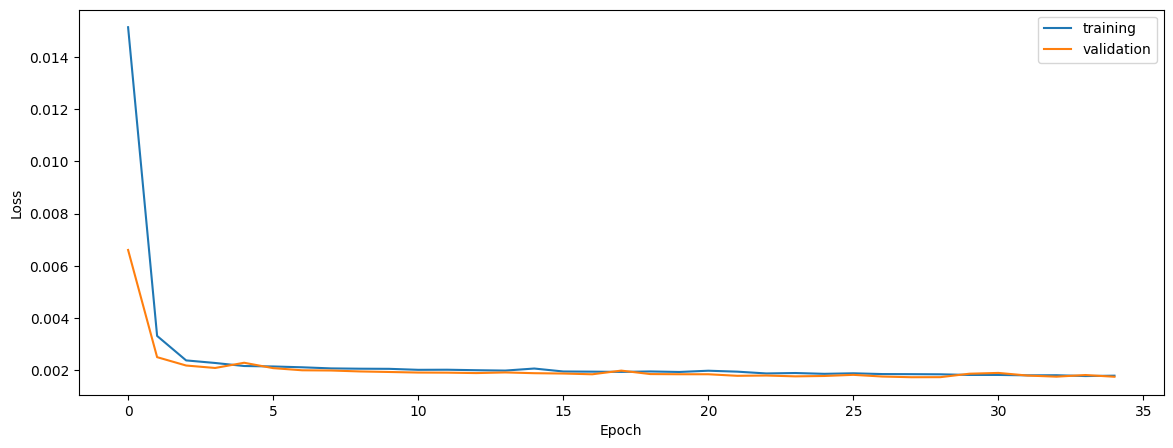

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


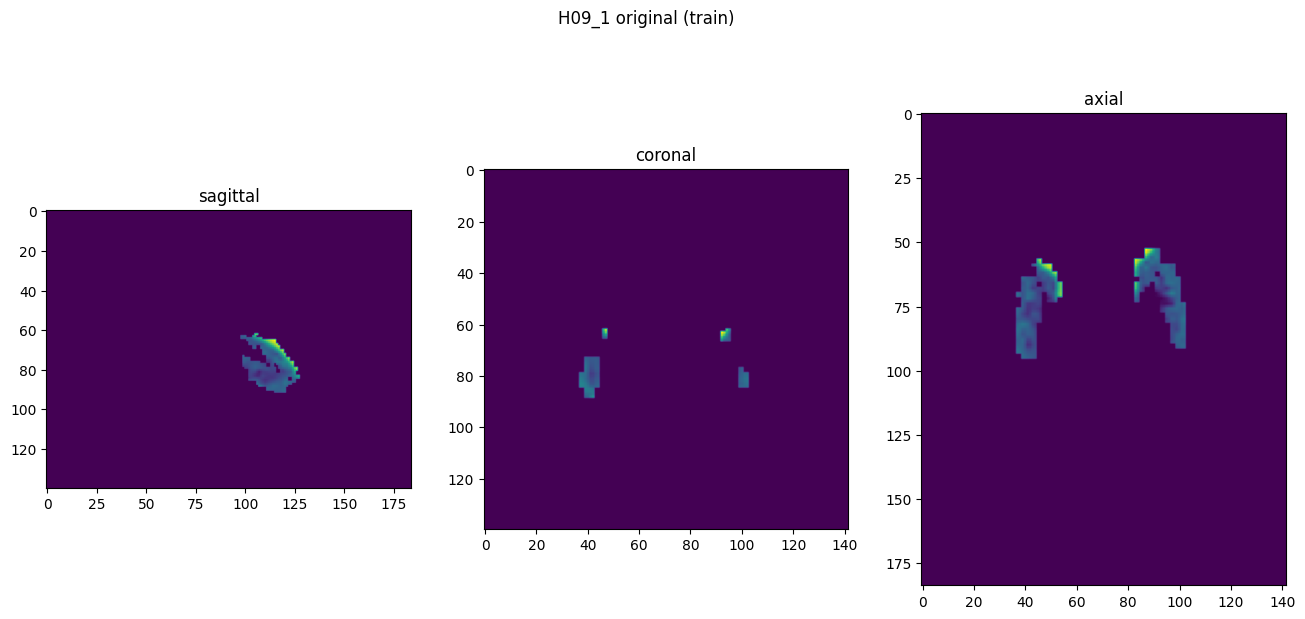

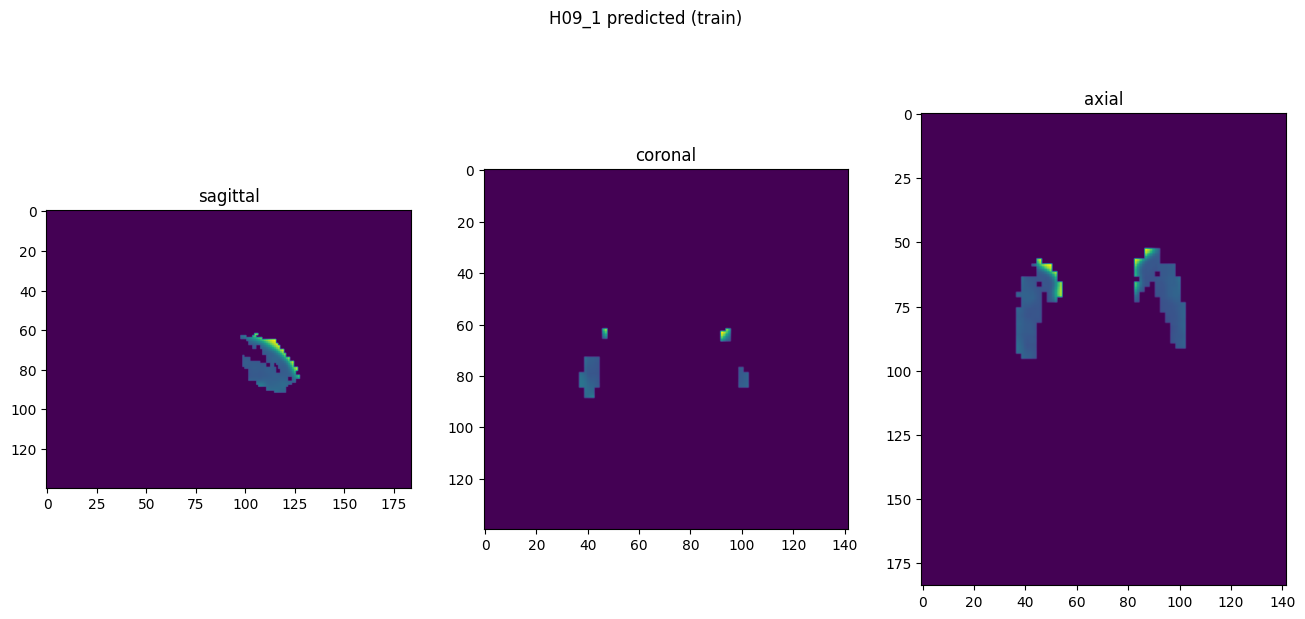

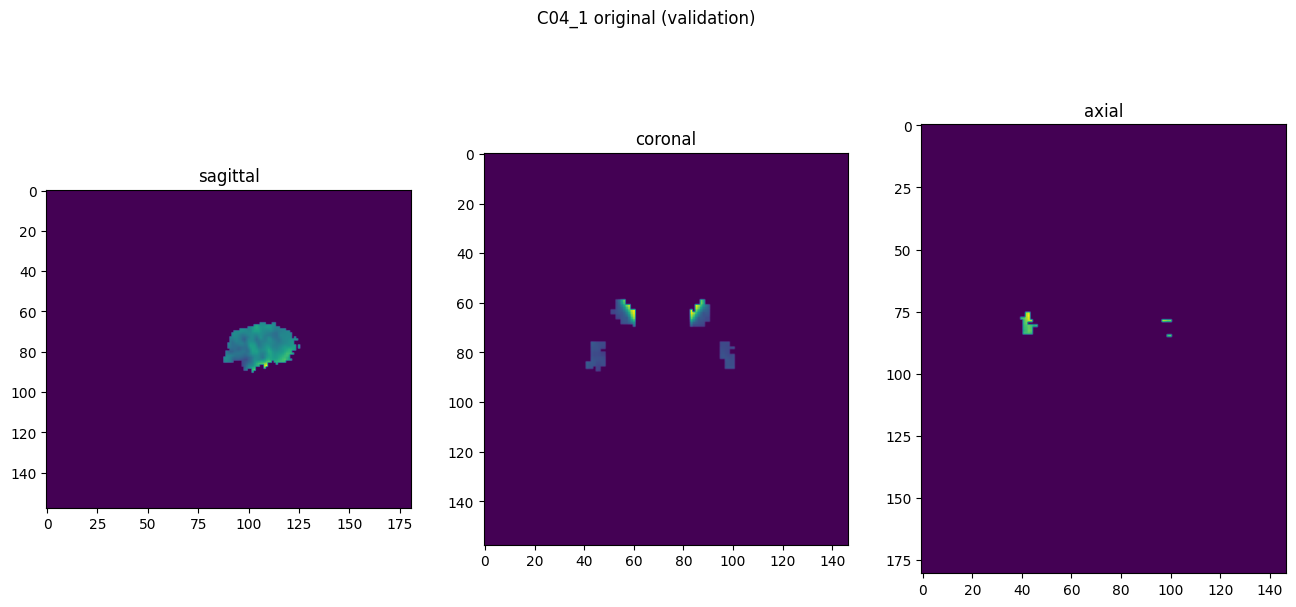

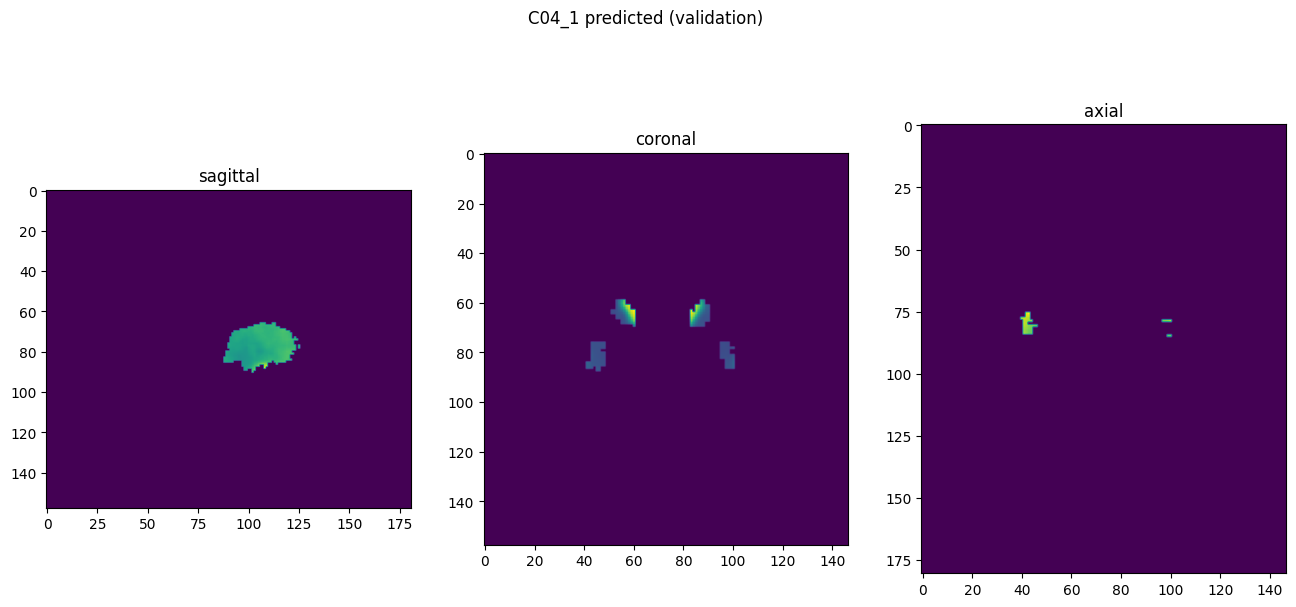

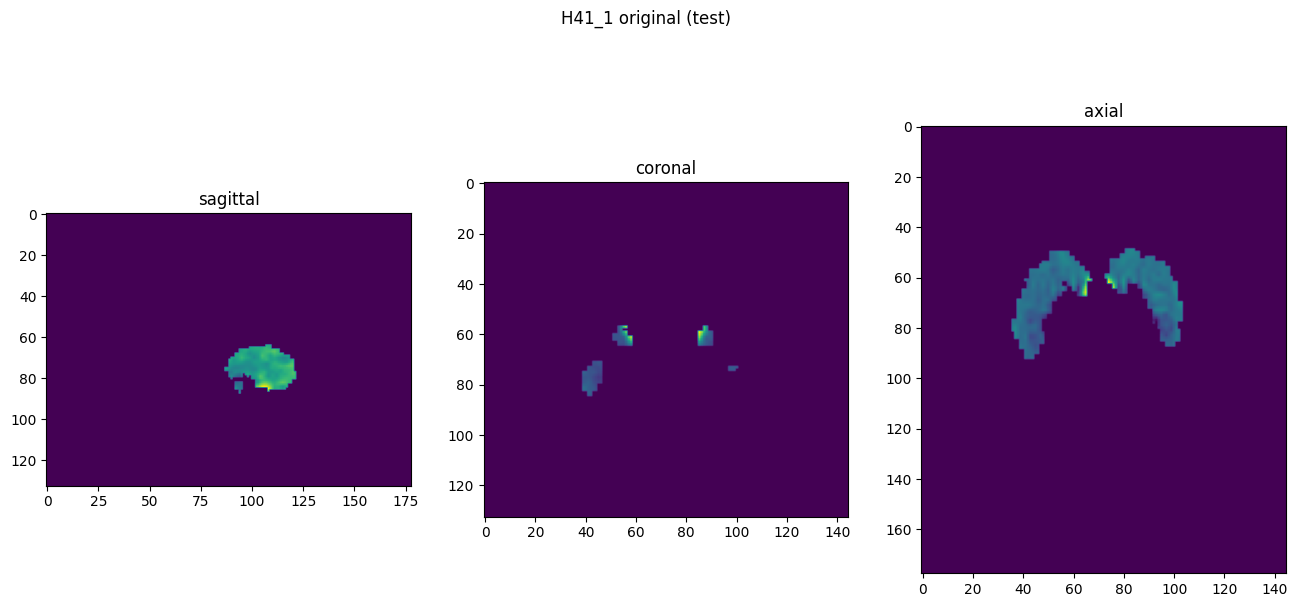

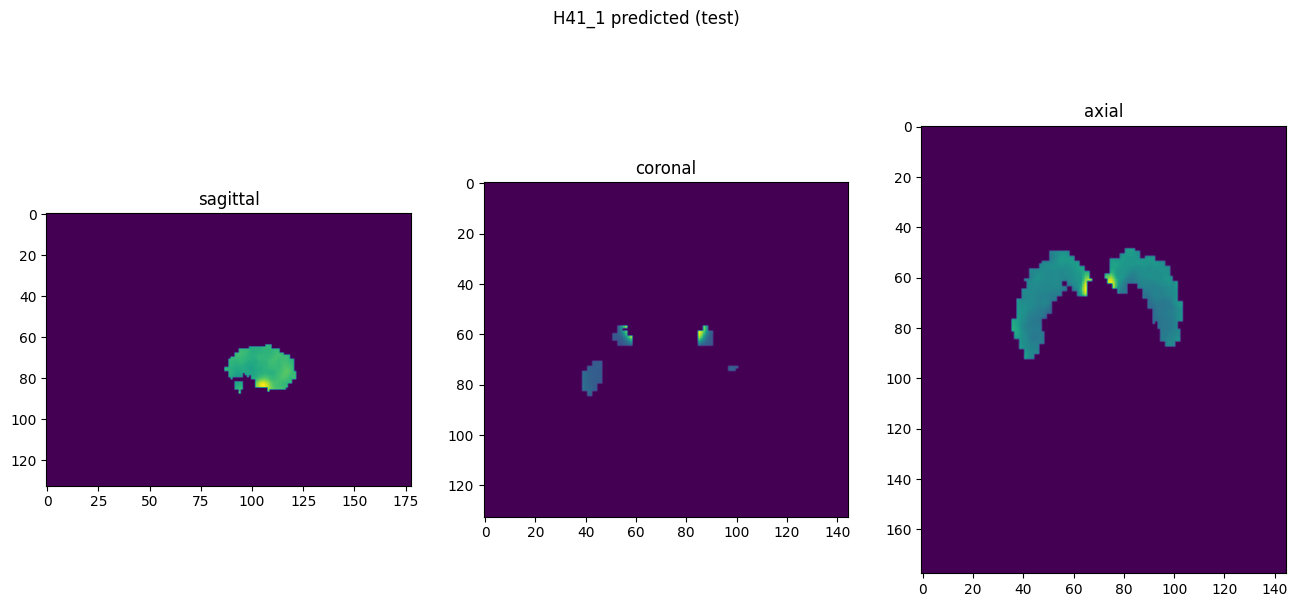

In [10]:
showResults(model, gen, threshold=None, background=False)